In [1]:
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
seq_dim=(6,6)

In [2]:
font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 16
}  
def setfigform_simple(xlabel, ylabel=None, xlimit = (None,None), ylimit = (None, None), xticks=None, yticks=None):
    # plt.legend(fontsize = 16, frameon=False),
    plt.xlabel(xlabel, fontdict = font)
    plt.ylabel(ylabel, fontdict = font)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    if xticks is not None:
      plt.xticks([])
    else:
      plt.xticks(fontsize = font['size'], fontname = "serif")
    if yticks is not None:
      plt.yticks([])
    else:
      plt.yticks(fontsize = font['size'], fontname = "serif")
    plt.tick_params(direction="in")

In [7]:
import torch
import seaborn as sns
from torch.autograd import grad as torchgrad

In [8]:

def HMCwithAccept(energy,x,length,steps,epsilon):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]

    torch.set_grad_enabled(False)
    E = energy(x)
    torch.set_grad_enabled(True)
    g = grad(x.requires_grad_())
    torch.set_grad_enabled(False)
    g = g.detach()
    for l in range(length):
        p = x.new_empty(size=x.size()).normal_()
        H = ((0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + E)
        xnew = x
        gnew = g
        for _ in range(steps):
            p = p- epsilon* gnew/2.
            xnew = (xnew + epsilon * p)
            torch.set_grad_enabled(True)
            gnew = grad(xnew.requires_grad_())
            torch.set_grad_enabled(False)
            xnew = xnew.detach()
            gnew = gnew.detach()
            p = p- epsilon* gnew/2.
        Enew = energy(xnew)
        Hnew = (0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + Enew
        diff = H-Hnew
        accept = (diff.exp() >= diff.uniform_()).to(x)

        E = accept*Enew + (1.-accept)*E
        acceptMask = accept.reshape(shape)
        x = acceptMask*xnew + (1.-acceptMask)*x
        g = acceptMask*gnew + (1.-acceptMask)*g
    torch.set_grad_enabled(True)

    return x, accept

def HMC(*args,**kwargs):
    x, _ = HMCwithAccept(*args,**kwargs)
    return x

class Lattice:
    def __init__(self,L, d, BC='periodic'):
        self.L = L 
        self.d = d
        self.shape = [L]*d 
        self.Nsite = L**d 
        self.BC = BC

    def move(self, idx, d, shift):
        coord = self.index2coord(idx)
        coord[d] += shift

        if self.BC != 'periodic':
            if (coord[d]>=self.L) or (coord[d]<0):
                return None
        #wrap around because of the PBC
        if (coord[d]>=self.L): coord[d] -= self.L; 
        if (coord[d]<0): coord[d] += self.L; 

        return self.coord2index(coord)

    def index2coord(self, idx):
        coord = np.zeros(self.d, int) 
        for d in range(self.d):
            coord[self.d-d-1] = idx%self.L;
            idx /= self.L
        return coord 

    def coord2index(self, coord):
        idx = coord[0]
        for d in range(1, self.d):
            idx *= self.L; 
            idx += coord[d]
        return idx 

class Hypercube(Lattice):
    def __init__(self,L, d, BC='periodic'):
        super(Hypercube, self).__init__(L, d, BC)
        self.Adj = np.zeros((self.Nsite,self.Nsite), int)
        for i in range(self.Nsite):
            for d in range(self.d):
                j = self.move(i, d, 1)

                if j is not None:
                    self.Adj[i, j] = 1.0
                    self.Adj[j, i] = 1.0

from scipy.linalg import eigh, inv, det 
import math
class Ising:
    def __init__(self,L,d,beta,name = None):
        if name is None:
            name = "Ising_l"+str(L)+"_d" +str(d)+"_beta"+str(beta)
        self.beta = beta
        self.lattice = Hypercube(L, d, 'periodic')
        self.K = self.lattice.Adj*beta
    
        w, v = eigh(self.K)    
        offset = 0.1-w.min()
        # print("offset", offset)
        self.K += np.eye(w.size)*offset
        sign, logdet = np.linalg.slogdet(self.K)
        #print (sign)
        #print (0.5*self.nvars[0] *(np.log(4.)-offset - np.log(2.*np.pi)) - 0.5*logdet)
        self.Kinv = torch.from_numpy(inv(self.K)).to(torch.float32)
        self.nvars = [L**d]

    def energy(self,x):
        assert len(x.shape) == 2
        return -(-0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.Kinv) * x.reshape(-1, self.nvars[0])).sum(dim=1) \
        + (torch.nn.Softplus()(2.*x.reshape(-1, self.nvars[0])) - x.reshape(-1, self.nvars[0]) - math.log(2.)).sum(dim=1))

    def lnZ(self,x):
        e = self.energy(x)
        Z = (torch.exp(-e)).sum()
        return torch.log(Z)


    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)


    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True).to(torch.float32)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()



In [16]:
import torch.autograd as autograd

def grad(energy, z):
    return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]


# Diffusion

In [17]:

def DiffusionwithDrift(energy,lnZ,x,D,length,epsilon,decay=0.9):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]
    epsilon = torch.tensor(epsilon)
    epsilon.requires_grad_(False)

    g = -grad(x.requires_grad_())*(torch.exp(-energy(x))/torch.exp(lnZ(x)))[:,None]

    g = g.detach()
    x = x.detach()
    x_t = []
    x_t.append(x)
    '''
    plt.figure(figsize=(17,5))
    plt.subplot(131)
    _ = plt.hist2d(x.reshape(-1,36)[:,0], x.reshape(-1,36)[:,1], bins=100)
    plt.colorbar()
    plt.subplot(132)
    _ = plt.hist(x.reshape(-1,36).sum(-1), bins=100, edgecolor='black', histtype='step', label="x")
    _ = plt.hist(g.reshape(-1,36).sum(-1), bins=100, edgecolor='red', histtype='step', label="$Grad_x(P)$")
    plt.legend()
    plt.subplot(133)
    _ = plt.scatter(x.reshape(-1), g.reshape(-1), s=5)
    plt.xlabel("x")
    plt.ylabel("$Grad_x(P)$")
    '''

    for l in range(1, length+1):
        z = torch.normal(0,1,size=x.size())
        x = x + 0.5 * epsilon * g * D + epsilon.sqrt() * z
        # x = x + 0.5 * epsilon * g
        g = -grad(x.requires_grad_())*(torch.exp(-energy(x))/torch.exp(lnZ(x)))[:,None]
        x = x.detach()
        g = g.detach()
        epsilon*=decay
        

        if l %100 == 0:
            plt.figure(figsize=(17,5))
            plt.subplot(131)
            _ = plt.hist2d(x.reshape(-1,36)[:,0], x.reshape(-1,36)[:,1], bins=100)
            plt.colorbar()
            plt.subplot(132)
            _ = plt.hist(x.reshape(-1,36).sum(-1), bins=100, edgecolor='black', histtype='step', label="x")
            _ = plt.hist(g.reshape(-1,36).sum(-1), bins=100, edgecolor='red', histtype='step', label="$Grad_x(P)$")
            plt.legend()
            plt.subplot(133)
            _ = plt.scatter(x.reshape(-1), g.reshape(-1), s=5)
            plt.xlabel("x")
            plt.ylabel("$Grad_x(P)$")

        x_t.append(x)
    return x_t


- Start distribution: N(0,1)
- End distribution: $k_BT=2.5J$
- Diffusion coeffient = 
    [0.00087473 0.00089455 0.00101424 0.00095392 0.00078433 0.00082617
     0.00078793 0.00121703 0.0008083  0.00076017 0.00064152 0.00078268
     0.00080268 0.00104615 0.0007548  0.00079117 0.00098635 0.00104748
     0.00099374 0.00086931 0.00081431 0.00067292 0.00089971 0.001025
     0.00094306 0.00090339 0.00100088 0.00083922 0.00086348 0.00085764
     0.00102415 0.000671   0.00067592 0.00078063 0.00068504 0.00080133]

KeyboardInterrupt: 

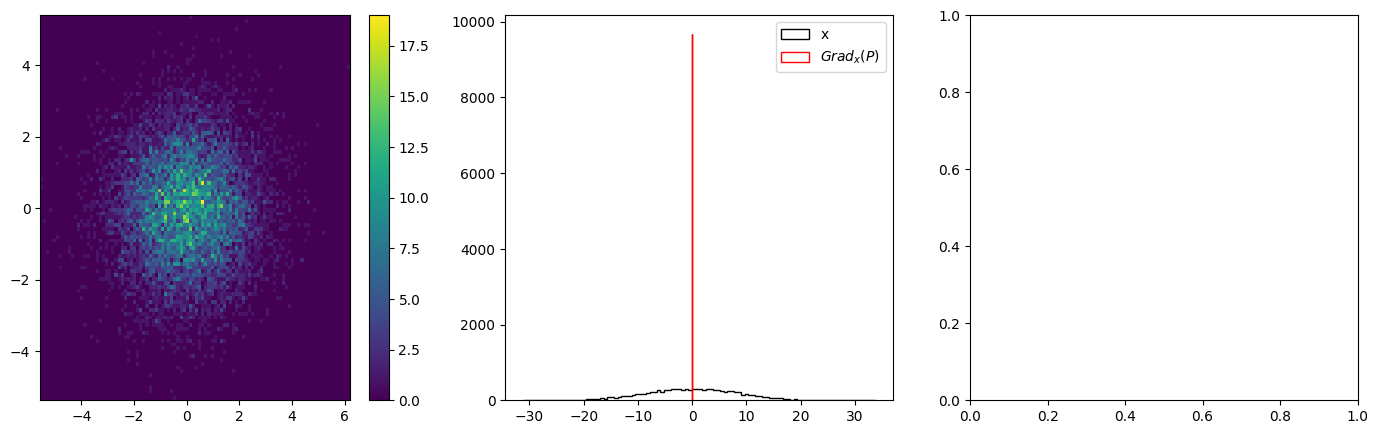

In [18]:
ising = Ising(6,2,0.4)
initial = torch.randn([10000]+ising.nvars,requires_grad=True)
thermolength = 1000
epsilon = 0.1
D = np.array([0.00087473, 0.00089455, 0.00101424, 0.00095392, 0.00078433, 0.00082617,
              0.00078793, 0.00121703, 0.0008083 , 0.00076017, 0.00064152, 0.00078268,
              0.00080268, 0.00104615, 0.0007548 , 0.00079117, 0.00098635, 0.00104748,
              0.00099374, 0.00086931, 0.00081431, 0.00067292, 0.00089971, 0.001025,
              0.00094306, 0.00090339, 0.00100088, 0.00083922, 0.00086348, 0.00085764,
              0.00102415, 0.000671  , 0.00067592, 0.00078063, 0.00068504, 0.00080133])
x_t = DiffusionwithDrift(ising.energy, ising.lnZ, initial, torch.from_numpy(D).to(torch.float32), thermolength, epsilon)

line_color = [plt.colormaps["gnuplot"](float(i)/float(thermolength+1)) for i in range(thermolength+1)]
plt.figure()
epsilon = 0.01
t=0
for i in range(0, len(x_t), 100):
    plt.hist(x_t[i].reshape(-1,36).sum(-1), bins=200, edgecolor=line_color[i], histtype='step', label="Time=%f, $\epsilon$=%f"%(t,epsilon))
    t+=epsilon
    epsilon*=0.9
plt.legend()

xx = x_t[-1]
plt.figure(figsize=(17, 5))
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)


# Implicit score matching

In [ ]:
# \psi(x), x is 2D
import torch
import torch.nn as nn
import torch.optim as optim
model_psi = nn.Sequential(
    nn.Linear(36, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer = optim.Adam(model_psi.parameters(), lr=3e-3)

In [ ]:
# Implicit score matching loss: L_{ISM}(\psi) = tr(\nabla_x \psi(x)) + \frac{1}{2}||\psi(x)||^2
def ism_loss(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    norm_loss = torch.norm(logp, dim=-1) ** 2/2
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

In [ ]:
dataset = xx3
def sample_batch_torch(size):
    idx = torch.randint(0, len(dataset), (size,))
    return dataset[idx]

In [ ]:
l_curve = []
print('[Training step, loss value]')
for training_step in range(5000):
    dataset = torch.tensor(sample_batch(3*10**2)).float()
    # Compute the loss.
    loss = ism_loss(model_psi, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((training_step % 10) == 0):
        l_curve.append([training_step, loss.item()])
    if ((training_step % 500) == 0):
        print([training_step, loss.item()])

In [ ]:
n_steps=9
eps=1e-2
decay=.9
temperature=1.0

xx =  torch.normal(0, 1, size=(10**5,36))
xx_t = []
xx_t.append(xx.detach().numpy())

for ii in range(n_steps):
    z_t = torch.rand(xx.size())
    xx = xx + (eps / 2) * model_psi(xx) + (np.sqrt(eps) * temperature * z_t)
    eps *= decay
    xx_t.append(xx.detach().numpy())
xx_t = np.array(xx_t)

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,:],bins=100, cmap='Blues',range=np.array([(-1.5, 2.0), (-1.5, 2.0)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2])
plt.show()

In [ ]:

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues')

plt.show()

In [ ]:

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(n_steps+1):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(xx_t[ii,:,:].sum(-1),bins=100)

plt.show()

# Flow matching with Gaussian probability path

In [ ]:
dataset = xx3.detach().numpy()
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)))
    return dataset[idx]

In [ ]:
sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001

#在格点上产生数据
NT = 10
NS = 1000
NS_xxtilde = 1000
xx_t = np.zeros((NT+1, NS, 36))
xx_t[0,:,:] = np.random.normal(size=(NS,36))

p_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
p_t_xx = np.zeros((NT, NS))
u_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde, 36))
u_t_xx = np.zeros((NT, NS, 36))

for tt in range(NT):
    print('Step: ' + str(tt))
    sigma_tt = 1 - (1-sigma_min) * tt / NT
    xxtilde = sample_batch(NS_xxtilde)
    for ii in range(NS):
        p_t_xx_xxtilde[tt,ii,:] = np.exp(-np.sum((xx_t[tt,ii,:].reshape(-1, 36)-xxtilde*tt/NT)**2,axis=1)/(2*sigma_tt**2))/((2*np.pi)**18*sigma_tt**36)
        u_t_xx_xxtilde[tt,ii,:,:] = (xxtilde - (1-sigma_min)*xx_t[tt,ii,:].reshape(-1, 36)) / sigma_tt
    p_t_xx[tt, :] = np.mean(p_t_xx_xxtilde[tt, :, :], axis = 1)
    for ii in range(NS):
        for jj in range(36):
            u_t_xx[tt,ii,jj] = np.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])
    xx_t[tt+1,:,:] = xx_t[tt,:,:] + u_t_xx[tt,:,:] * 0.1

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7


/tmp/ipykernel_1873410/3291082697.py:27: RuntimeWarning: invalid value encountered in divide
  u_t_xx[tt,ii,jj] = np.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])


Step: 8
Step: 9


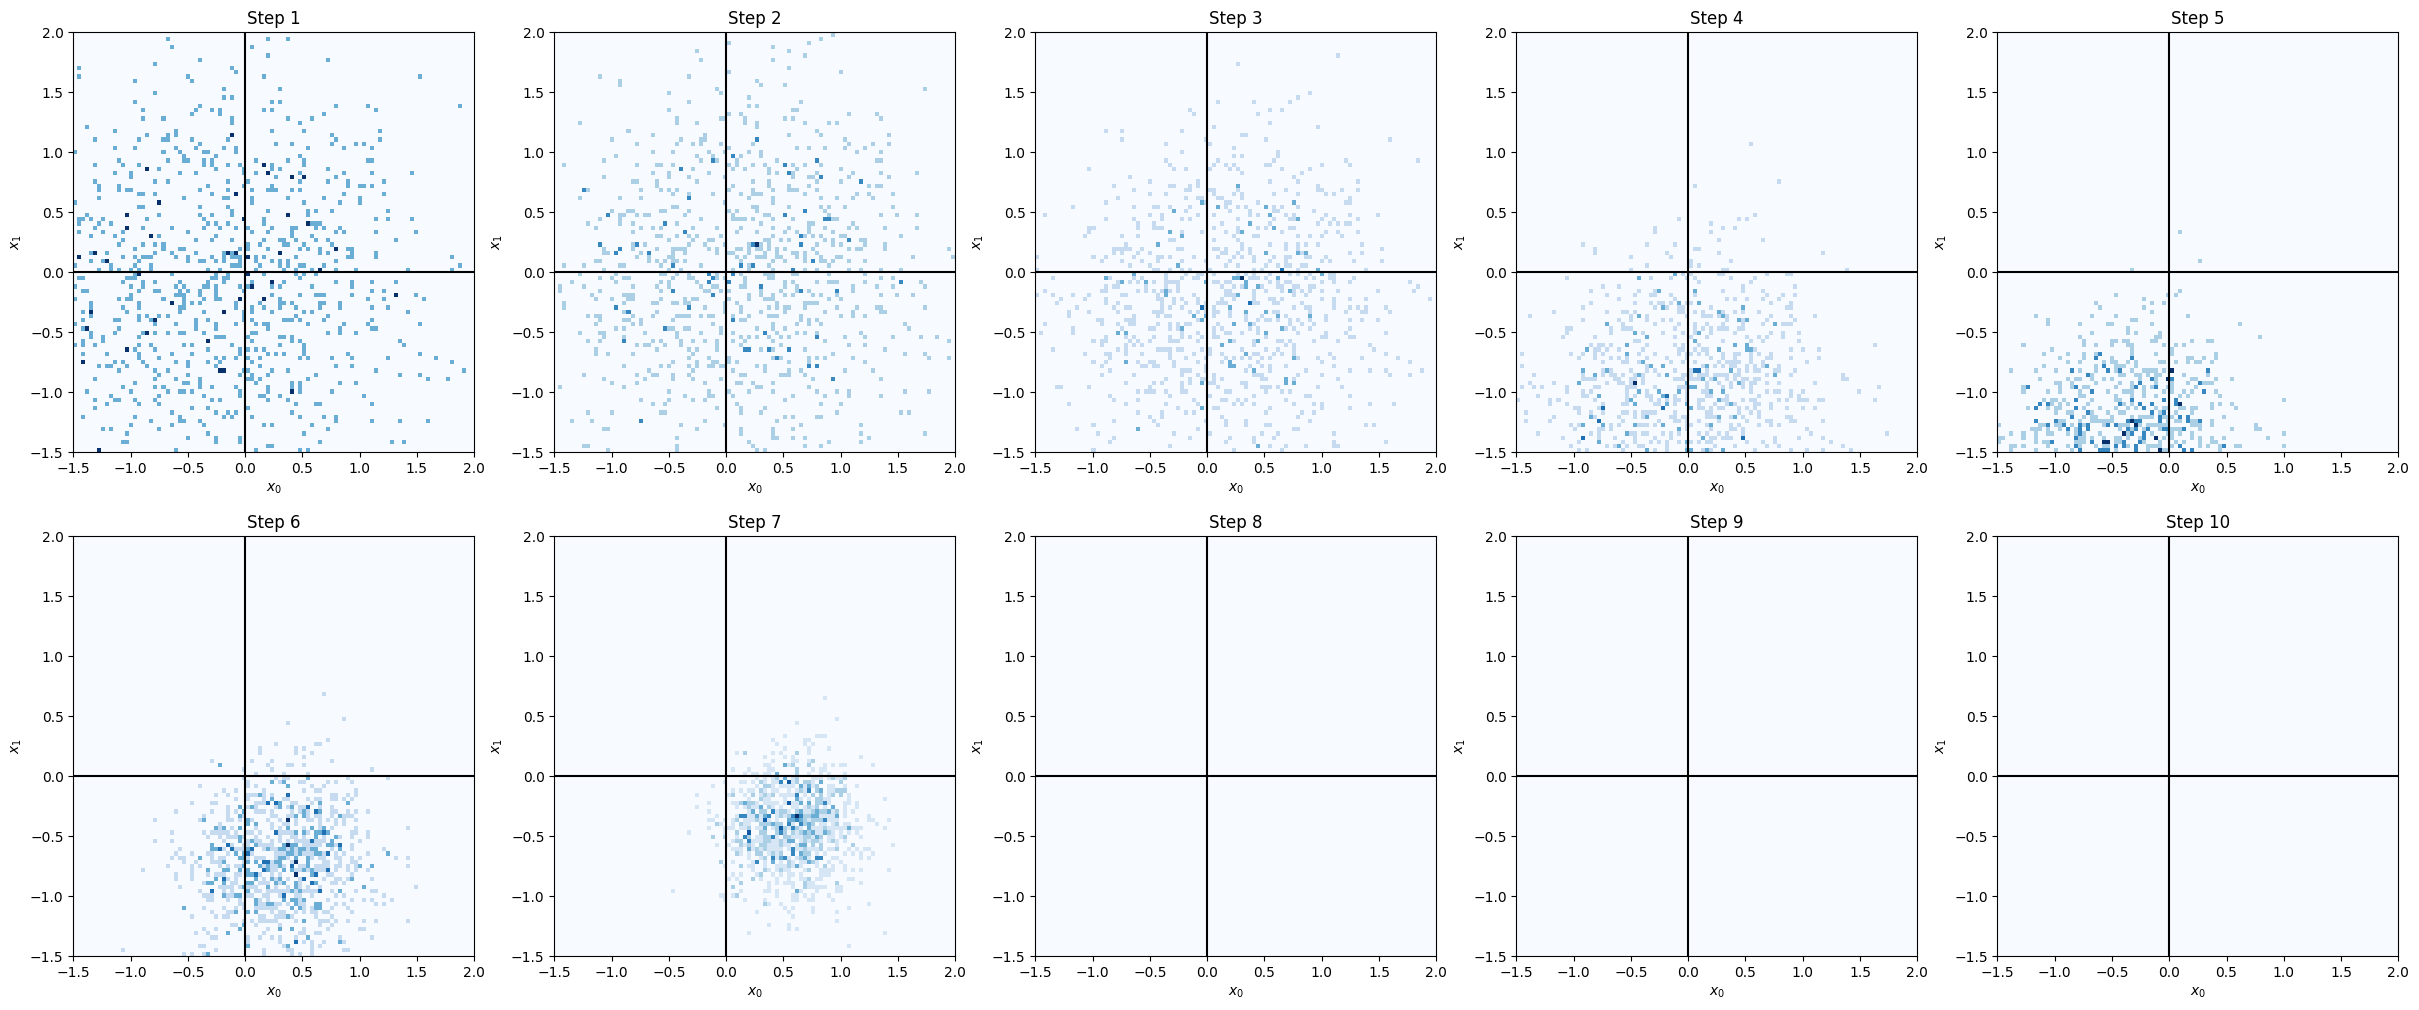

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii+1))
    axes[ii_x,ii_y].hist2d(xx_t[(ii+1)*1,:,0], xx_t[ii+1,:,1],bins=100, cmap='Blues',range=np.array([(-1.5, 2.0), (-1.5, 2.0)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2]) 
    axes[ii_x,ii_y].axhline(0, c="k")
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlabel("$x_{0}$")
    axes[ii_x,ii_y].set_ylabel("$x_{1}$")
plt.show()

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

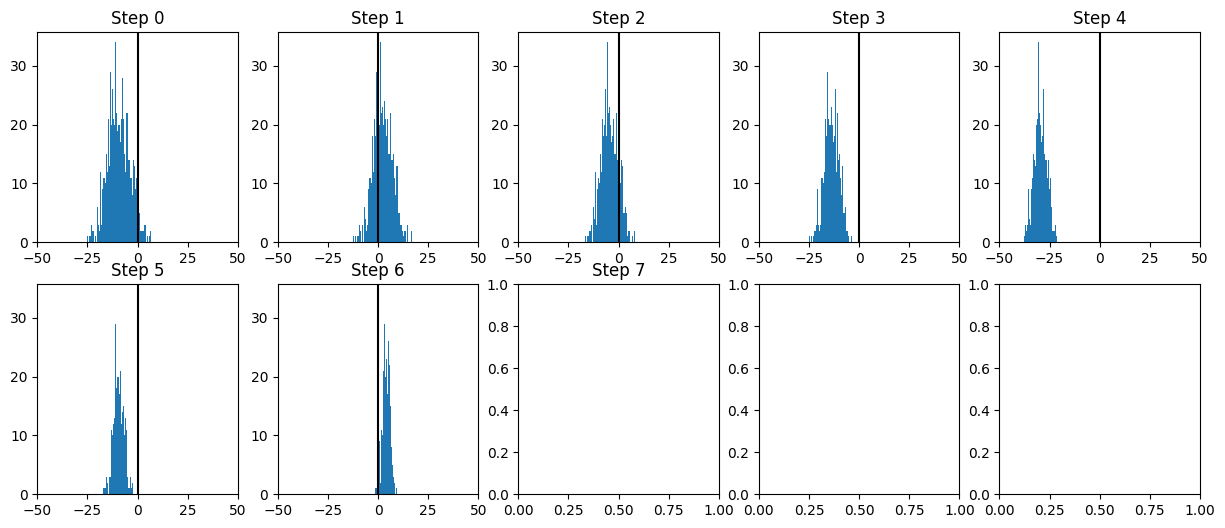

In [ ]:

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(xx_t[(ii+1)*1,:,:].sum(-1),bins=100)
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlim((-50,50))
plt.show()

# CFM by Gaussian probability path

In [13]:
def cfm_loss(model, samples, u_t_label, train=False):
    samples.requires_grad_(True)
    u_t_model = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(u_t_label - u_t_model, dim = -1) ** 2 / 2.
    return norm_loss.mean(-1)

In [14]:
dataset = xx3.detach().numpy()
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)), size=size)
    return dataset[idx]

In [15]:
dataset_prior = xx0.detach().numpy()
def sample_batch_prior(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset_prior)), size=size)
    return dataset_prior[idx]

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

model_u_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer = optim.Adam(model_u_t.parameters(), lr=3e-3)

sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001


l_curve = []

sample_size = 10**3
print('[Time step, loss value]')
for training_step in range(10000):
    sample_x_tilde = sample_batch(sample_size).reshape([-1,36])
    sample_t = 1 - np.random.rand(sample_size).reshape([-1,1])
    sigma_t =  1 - (1-sigma_min) * sample_t 
    # sample_x = np.random.normal(size=(sample_size,36))
    sample_x = sample_batch_prior(size=sample_size).reshape([-1,36])
    sample_x *= sigma_t
    sample_x += sample_t * sample_x_tilde
    samples = np.concatenate([sample_t, sample_x], axis = 1)
    u_t_xx = (sample_x_tilde - (1 - sigma_min)*sample_x) / sigma_t
    u_t_label = torch.tensor(u_t_xx).float()
    loss = cfm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    
    if ((training_step % 20) == 0):
        l_curve.append([training_step,loss.item()])
    if ((training_step % 200) == 0):
        print([training_step,loss.item()])

[Time step, loss value]
[0, 195.1463623046875]
[200, 73.82591247558594]
[400, 72.04316711425781]
[600, 71.68022918701172]
[800, 69.00209045410156]
[1000, 65.95235443115234]
[1200, 72.04814910888672]
[1400, 65.56324005126953]
[1600, 67.25858306884766]
[1800, 69.7652359008789]
[2000, 66.25464630126953]
[2200, 65.6559066772461]
[2400, 67.22952270507812]
[2600, 63.64522933959961]
[2800, 67.51808166503906]
[3000, 64.21720886230469]
[3200, 64.6235122680664]
[3400, 63.854549407958984]
[3600, 66.95785522460938]
[3800, 65.08638763427734]
[4000, 64.8718032836914]
[4200, 66.90709686279297]
[4400, 63.525115966796875]
[4600, 68.03350830078125]
[4800, 65.86045837402344]
[5000, 62.71426010131836]
[5200, 62.37250518798828]
[5400, 63.724971771240234]
[5600, 65.33097076416016]
[5800, 60.48146057128906]
[6000, 61.917850494384766]
[6200, 61.68667984008789]
[6400, 64.5024642944336]
[6600, 62.469783782958984]
[6800, 62.66900634765625]
[7000, 63.709136962890625]
[7200, 63.95994186401367]
[7400, 61.5930252075

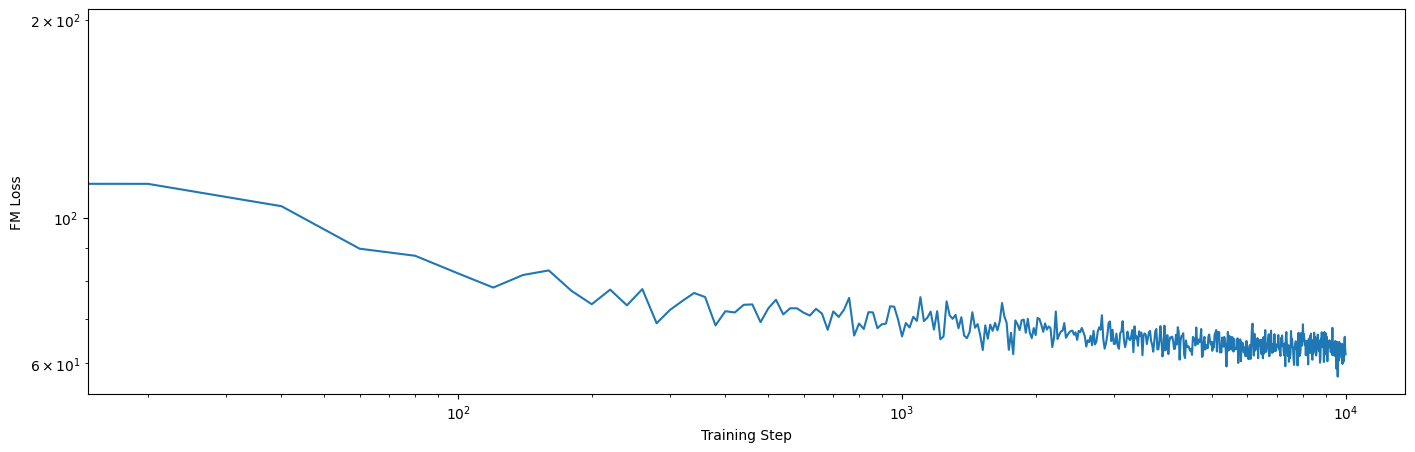

In [17]:
l_curve_fm = np.array(l_curve)
plt.loglog(l_curve_fm[:,0],l_curve_fm[:,1])
plt.xlabel('Training Step')
plt.ylabel('FM Loss')
plt.show()

In [18]:
def plot_flow(model_u_t):
    sample_size = 10**5
    xx =  torch.normal(0, 1, size=(sample_size ,36))
    xx_t = []
    xx_t.append(xx.detach().numpy())

    for ii in range(10):
        tt = ii / 10
        samples = torch.cat((torch.ones(sample_size, 1)*tt, xx), axis = 1)
        u_t = model_u_t(samples)
        xx = xx + u_t * 0.1
        xx_t.append(xx.detach().numpy())
    xx_t = np.array(xx_t)
    plt.figure()
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

    for ii in range(1,11):
        ii_y = (ii-1) % 5
        ii_x = (ii-1) // 5
        axes[ii_x,ii_y].set_title('Step '+str(ii))
        axes[ii_x,ii_y].hist2d(xx_t[ii,:,0], xx_t[ii,:,1],bins=100, cmap='Blues',range=np.array([(-8, 8), (-8, 8)]))
        axes[ii_x,ii_y].set_xlim([-8,8])
        axes[ii_x,ii_y].set_ylim([-8,8])
    
    plt.show()
    plt.figure()
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

    for ii in range(1,11):
        ii_y = (ii-1) % 5
        ii_x = (ii-1) // 5
        axes[ii_x,ii_y].set_title('Step '+str(ii))
        axes[ii_x,ii_y].hist(xx_t[ii,:,:].sum(-1),bins=100)
    
    plt.show()

<Figure size 1700x500 with 0 Axes>

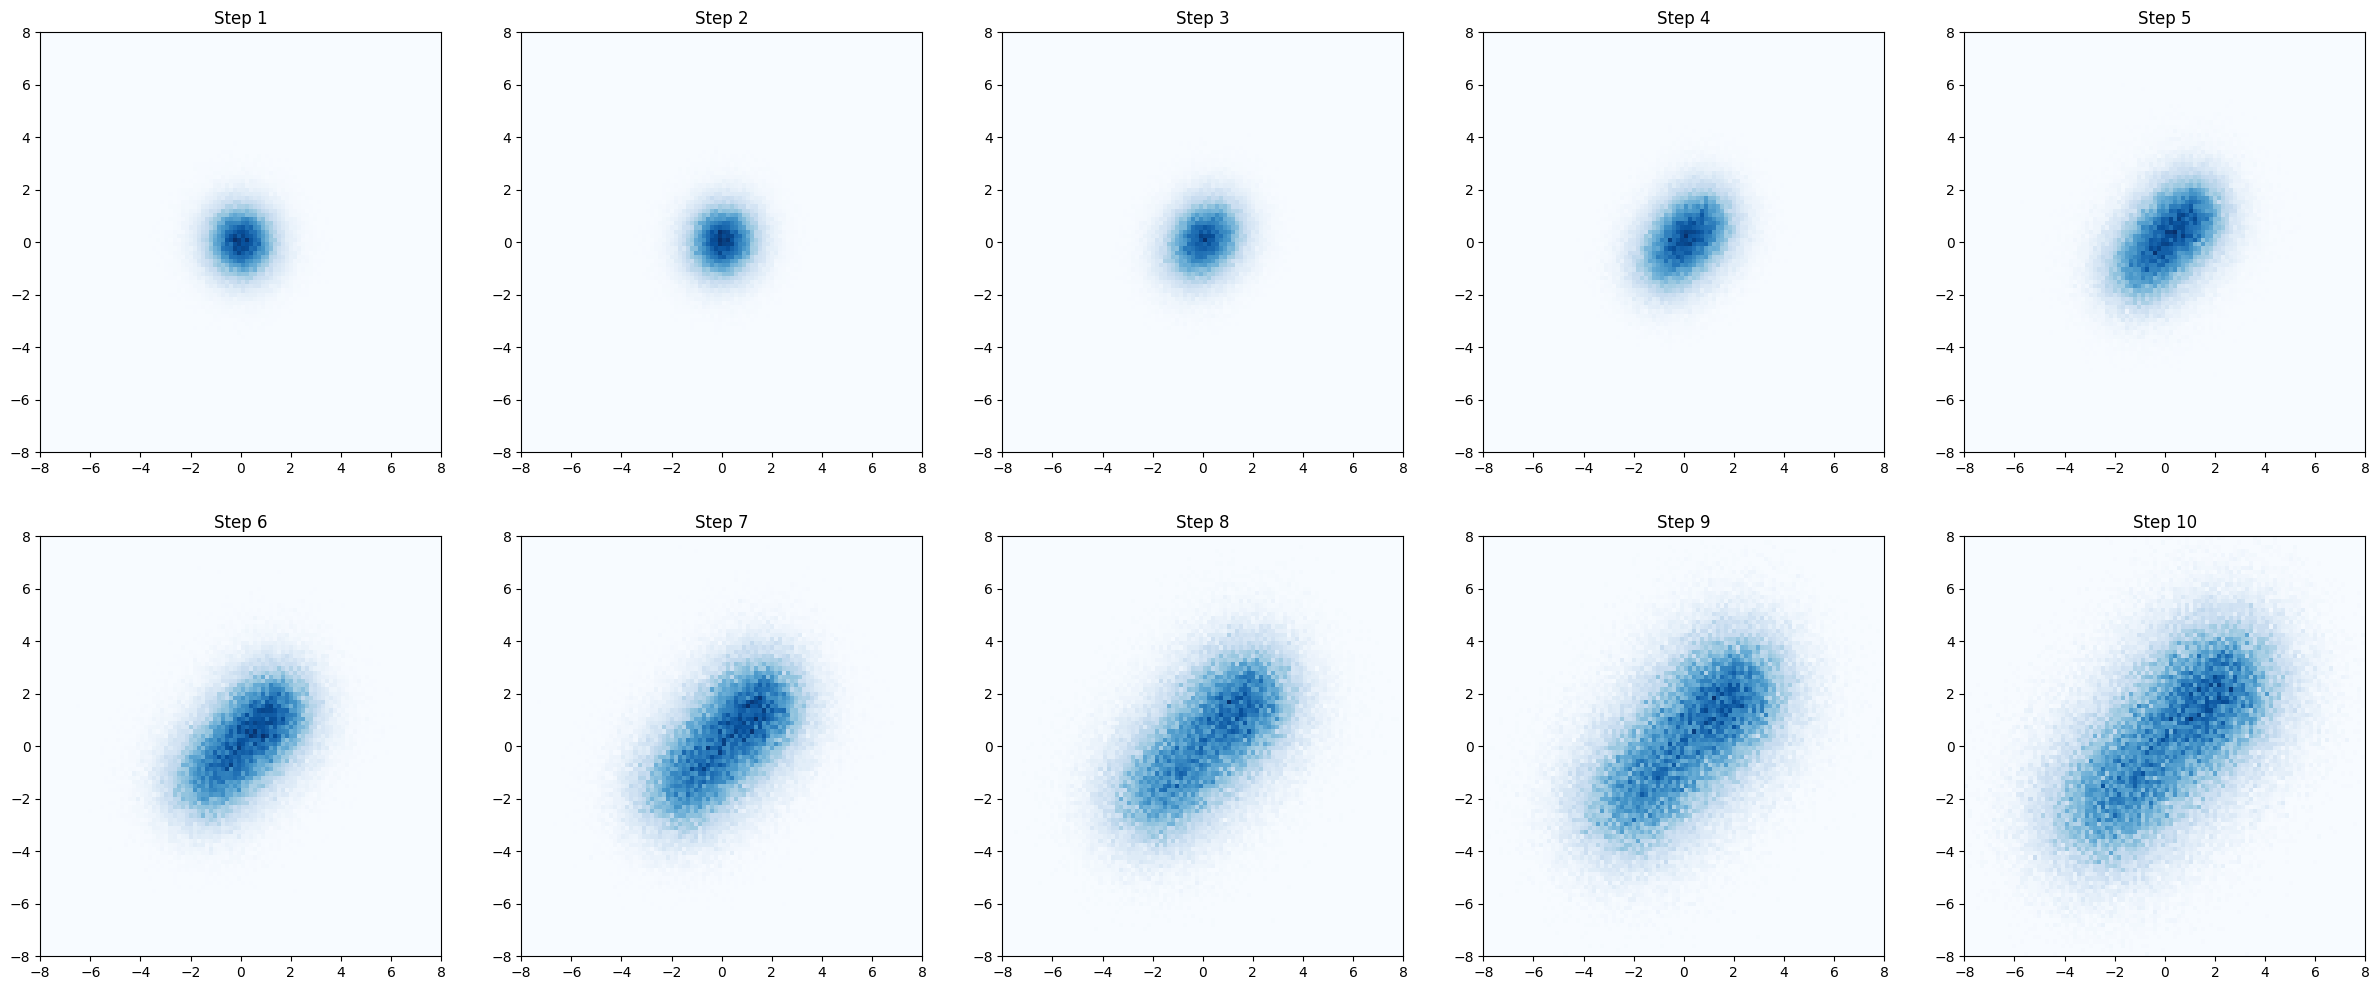

<Figure size 1700x500 with 0 Axes>

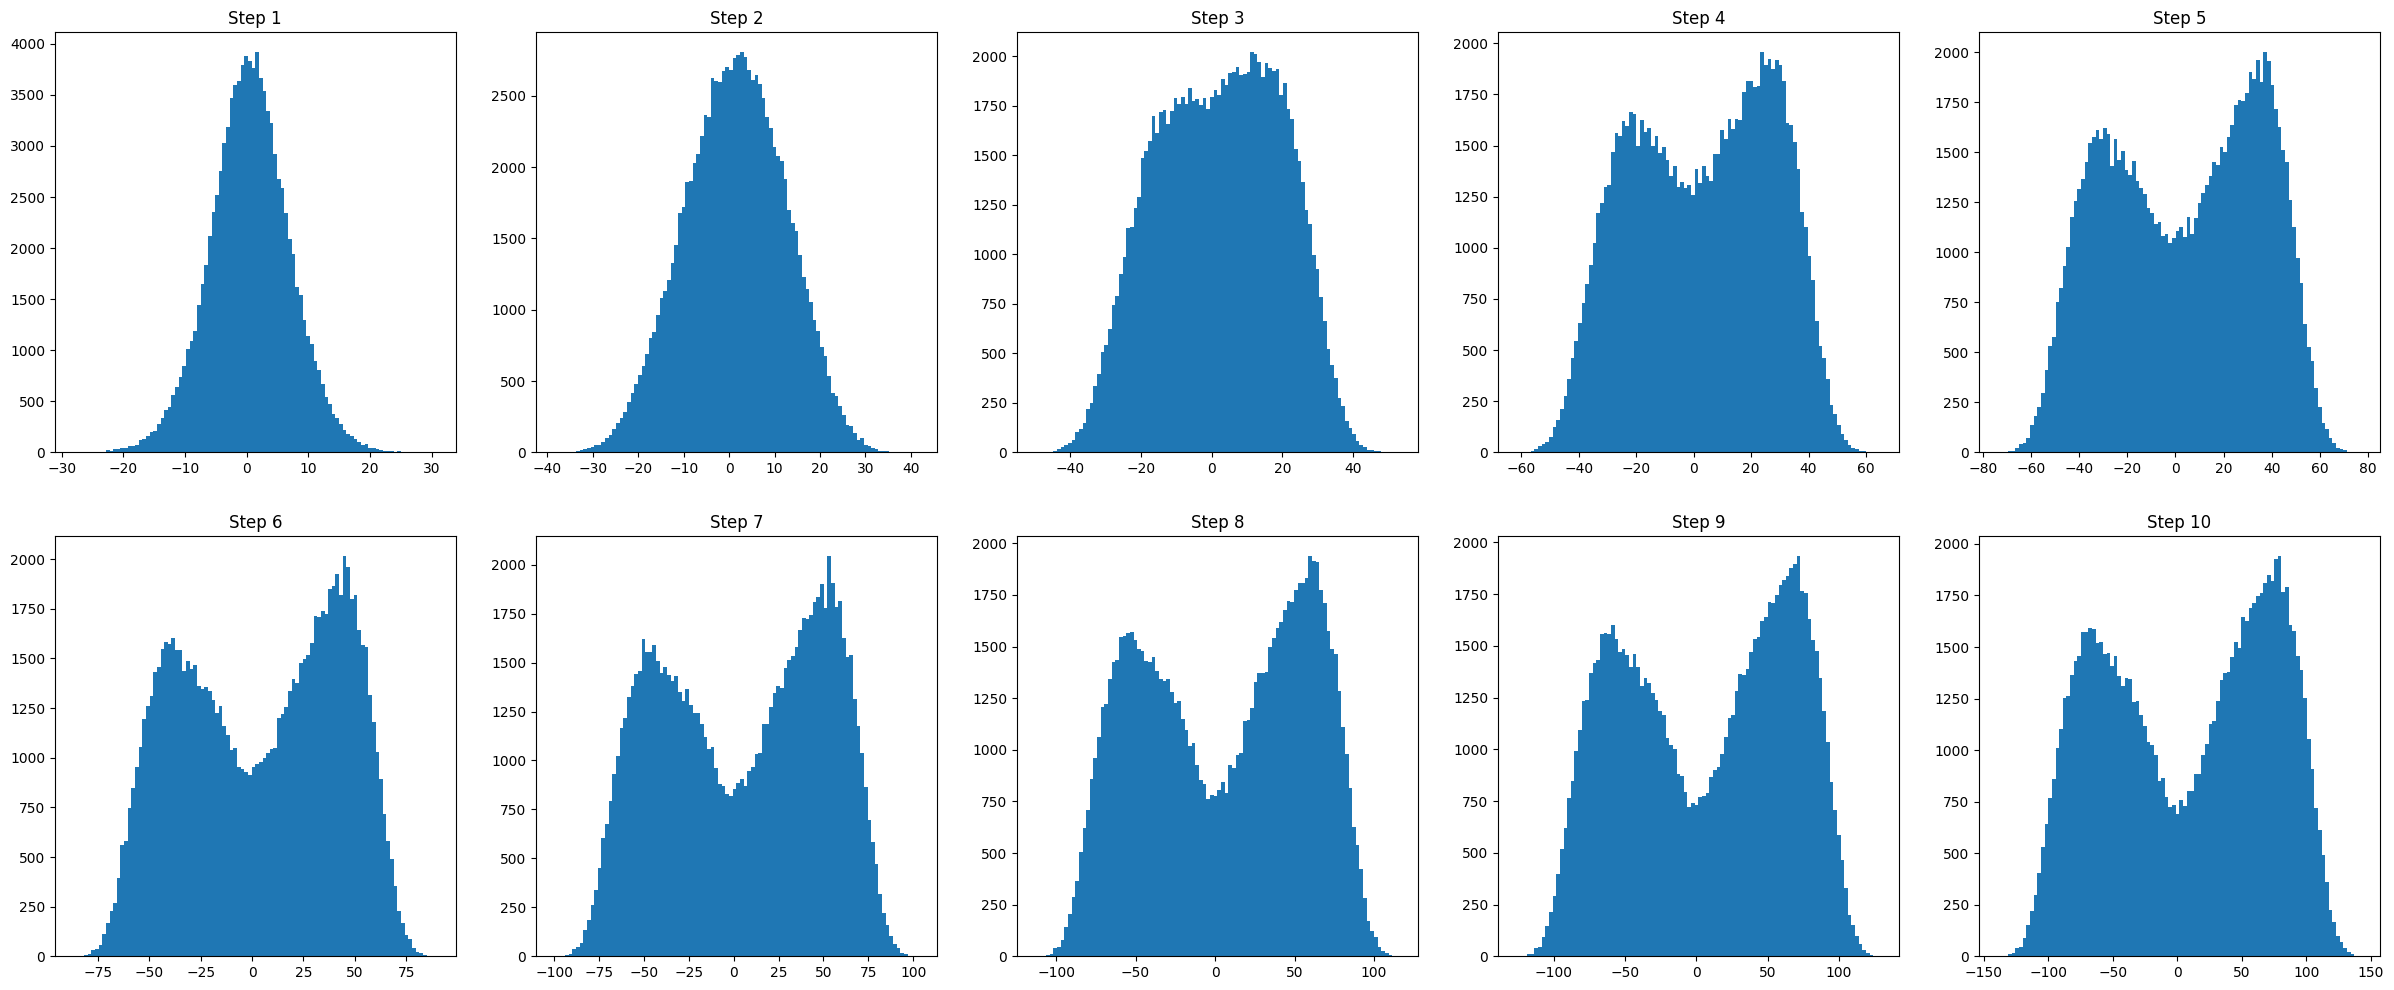

In [19]:
plot_flow(model_u_t)

# Flow matching with temperature reweighted probability path

In [20]:
dataset = xx2.detach().numpy()
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)), size=size)
    return dataset[idx]

Step: 0; Beta: 0.115


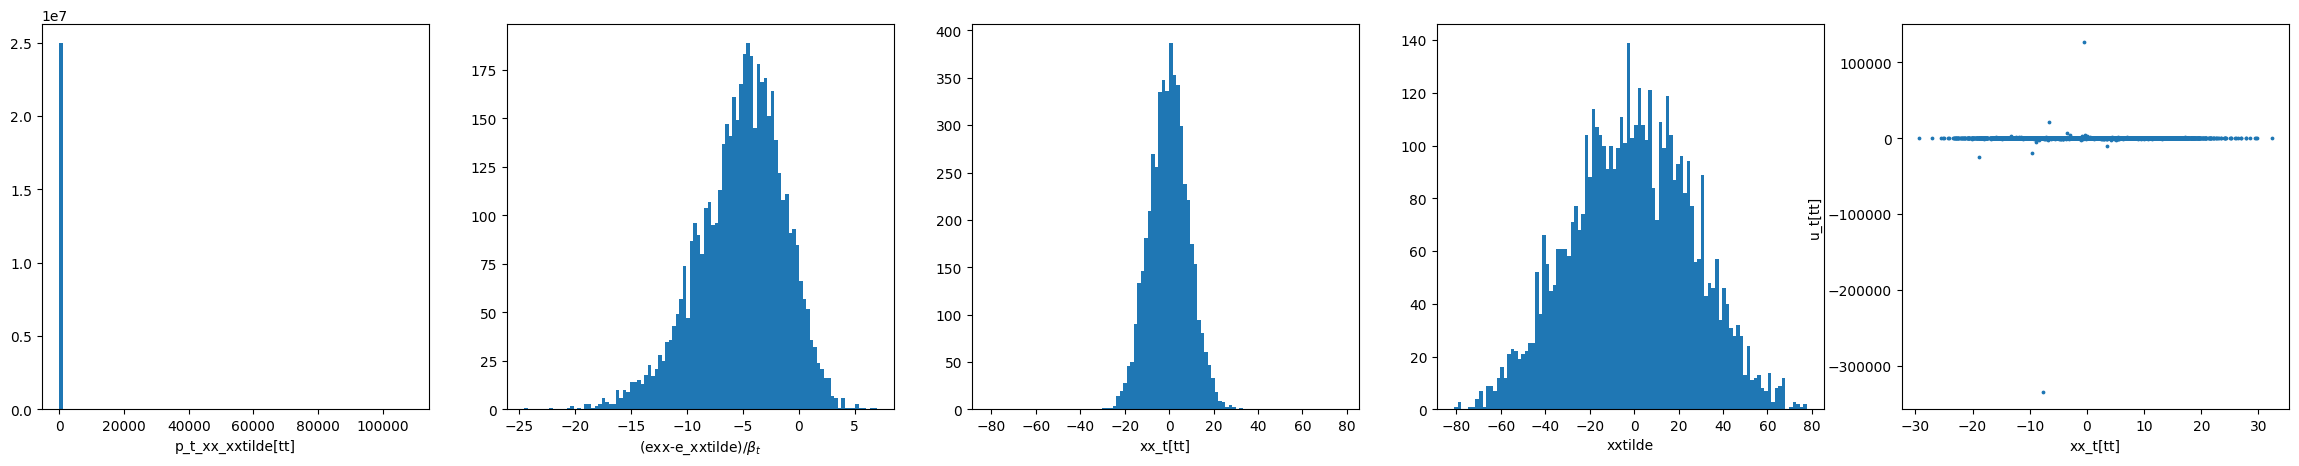

Step: 1; Beta: 0.13


/tmp/ipykernel_2555864/1382655883.py:53: RuntimeWarning: divide by zero encountered in divide
  plt.hist((p_t_xx_xxtilde[tt]/p_t_xx[tt, :]).reshape(-1), bins=100)
/tmp/ipykernel_2555864/1382655883.py:53: RuntimeWarning: overflow encountered in divide
  plt.hist((p_t_xx_xxtilde[tt]/p_t_xx[tt, :]).reshape(-1), bins=100)
/tmp/ipykernel_2555864/1382655883.py:53: RuntimeWarning: invalid value encountered in divide
  plt.hist((p_t_xx_xxtilde[tt]/p_t_xx[tt, :]).reshape(-1), bins=100)


ValueError: supplied range of [0.0, inf] is not finite

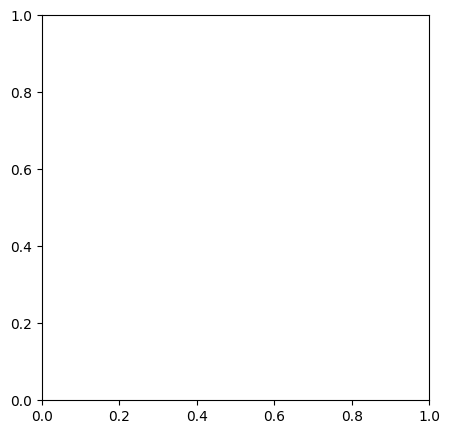

In [26]:
from torch.autograd.functional import jacobian

sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001

#在格点上产生数据
NT = 10
NS = 5000
NS_xxtilde = 5000
xx_t = np.zeros((NT+1, NS, 36))
# xx_t[0,:,:] = np.random.normal(loc=0.0, scale=1.0, size=(NS,36))
ising0 = Ising(6,2,0.1)
xx_t[0,:,:] = ising0.sample(NS)
xxtilde_prev = xx_t[0,:,:]

p_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
logp_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde))
p_t_xx = np.zeros((NT, NS))
u_t_xx_xxtilde = np.zeros((NT, NS, NS_xxtilde, 36))
u_t_xx = np.zeros((NT, NS, 36))
ising_t = Ising(6,2,0.25)
for tt in range(NT):
    beta_tt = 0.1+(0.25-0.1)*(tt+1)/NT
    print('Step: ' + str(tt) + "; Beta: "+str(beta_tt))
    # ising_t = Ising(6,2,0.1+Delta_beta-sigma_tt*Delta_beta)
    
    # xxtilde = sample_batch(NS_xxtilde)
    # if tt == 0:
    #     xxtilde = ising_t.sample(NS_xxtilde, thermalSteps=1000, initial=torch.from_numpy(xxtilde_prev).to(torch.float32)).detach().numpy()
    # else:
    #     xxtilde = ising_t.sample(NS_xxtilde, thermalSteps=500, initial=torch.from_numpy(xxtilde_prev).to(torch.float32)).detach().numpy()
    # xxtilde_prev = xxtilde
    xxtilde = sample_batch(NS)
    e_xxtilde = ising_t.energy(torch.from_numpy(xxtilde).to(torch.float32).reshape(NS_xxtilde,36)).detach().numpy()
    # lnZ = ising_t.lnZ(torch.from_numpy(xxtilde).reshape(NS_xxtilde,36)).detach().numpy()
    # print(lnZ)
    e_xx_list = []
    for ii in range(NS):
        e_xx = ising_t.energy(torch.from_numpy(xx_t[tt,ii,:]).to(torch.float32).reshape(1,36)).detach().numpy()
        e_xx_list.append(e_xx[0])
        jac_e_xx = jacobian(ising_t.energy, torch.from_numpy(xx_t[tt,ii,:]).to(torch.float32).reshape(1,36)).detach().numpy()
        # p_t_xx_xxtilde[tt,ii,:] = np.exp(-(e_xx-e_xxtilde))/np.exp(lnZ)
        logp_t_xx_xxtilde[tt,ii,:] = -(e_xx-e_xxtilde) # -lnZ
        # u_t_xx_xxtilde[tt,ii,:,:] = (xxtilde - (1-sigma_min)*xx_t[tt,ii,:].reshape(-1, 36)) / sigma_tt #  / (Delta_beta/NT)
        u_t_xx_xxtilde[tt,ii,:,:] = -(0.25-0.1)/beta_tt*e_xx/jac_e_xx

    p_t_xx_xxtilde[tt] = np.exp(logp_t_xx_xxtilde[tt].reshape(NS,NS_xxtilde)-logp_t_xx_xxtilde[tt].max())
    p_t_xx[tt, :] = np.mean(p_t_xx_xxtilde[tt, :, :], axis = 1)

    plt.figure(figsize=(29,5))
    plt.subplot(151)
    plt.hist((p_t_xx_xxtilde[tt]/p_t_xx[tt, :]).reshape(-1), bins=100)
    plt.xlabel("p_t_xx_xxtilde[tt]")
    plt.subplot(152)
    plt.hist(e_xx-e_xxtilde, bins=100)
    plt.xlabel(r"(exx-e_xxtilde)/$\beta_t$")
    plt.subplot(153)
    plt.hist(xx_t[tt,:,:].sum(-1),bins=100, range=(xxtilde.sum(-1).min(), xxtilde.sum(-1).max()))
    plt.xlabel("xx_t[tt]")
    plt.subplot(154)
    plt.hist(xxtilde.sum(-1),bins=100)
    plt.xlabel("xxtilde")

    # plt.figure(figsize=(11,5))
    # plt.subplot(121)
    # plt.hist(xx_t[tt,:,:].sum(-1),bins=100, range=(xxtilde.sum(-1).min(), xxtilde.sum(-1).max()))
    # plt.xlabel("xx_t[tt]")
    # plt.subplot(122)
    # plt.hist(xxtilde.sum(-1),bins=100)
    # plt.xlabel("xxtilde")
    # plt.show()

    for ii in range(NS):
        for jj in range(36):
            u_t_xx[tt,ii,jj] = np.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])

    plt.subplot(155)
    # plt.hist(u_t_xx[tt].sum(-1) * Delta_beta/NT,bins=100)
    # plt.xlabel("u_t[tt]")
    plt.scatter(xx_t[tt].sum(-1).reshape(-1), u_t_xx[tt].sum(-1) * 1./NT, s=3)
    plt.xlabel("xx_t[tt]")
    plt.ylabel("u_t[tt]")
    plt.show()

    # u_t_xx[tt] = (xxtilde - (1-sigma_min)*xx_t[tt])/ (Delta_beta/NT)
    xx_t[tt+1,:,:] = xx_t[tt,:,:] + u_t_xx[tt,:,:] * 1./NT

In [ ]:
torch.exp(torch.tensor(-80.))

tensor(1.8049e-35)

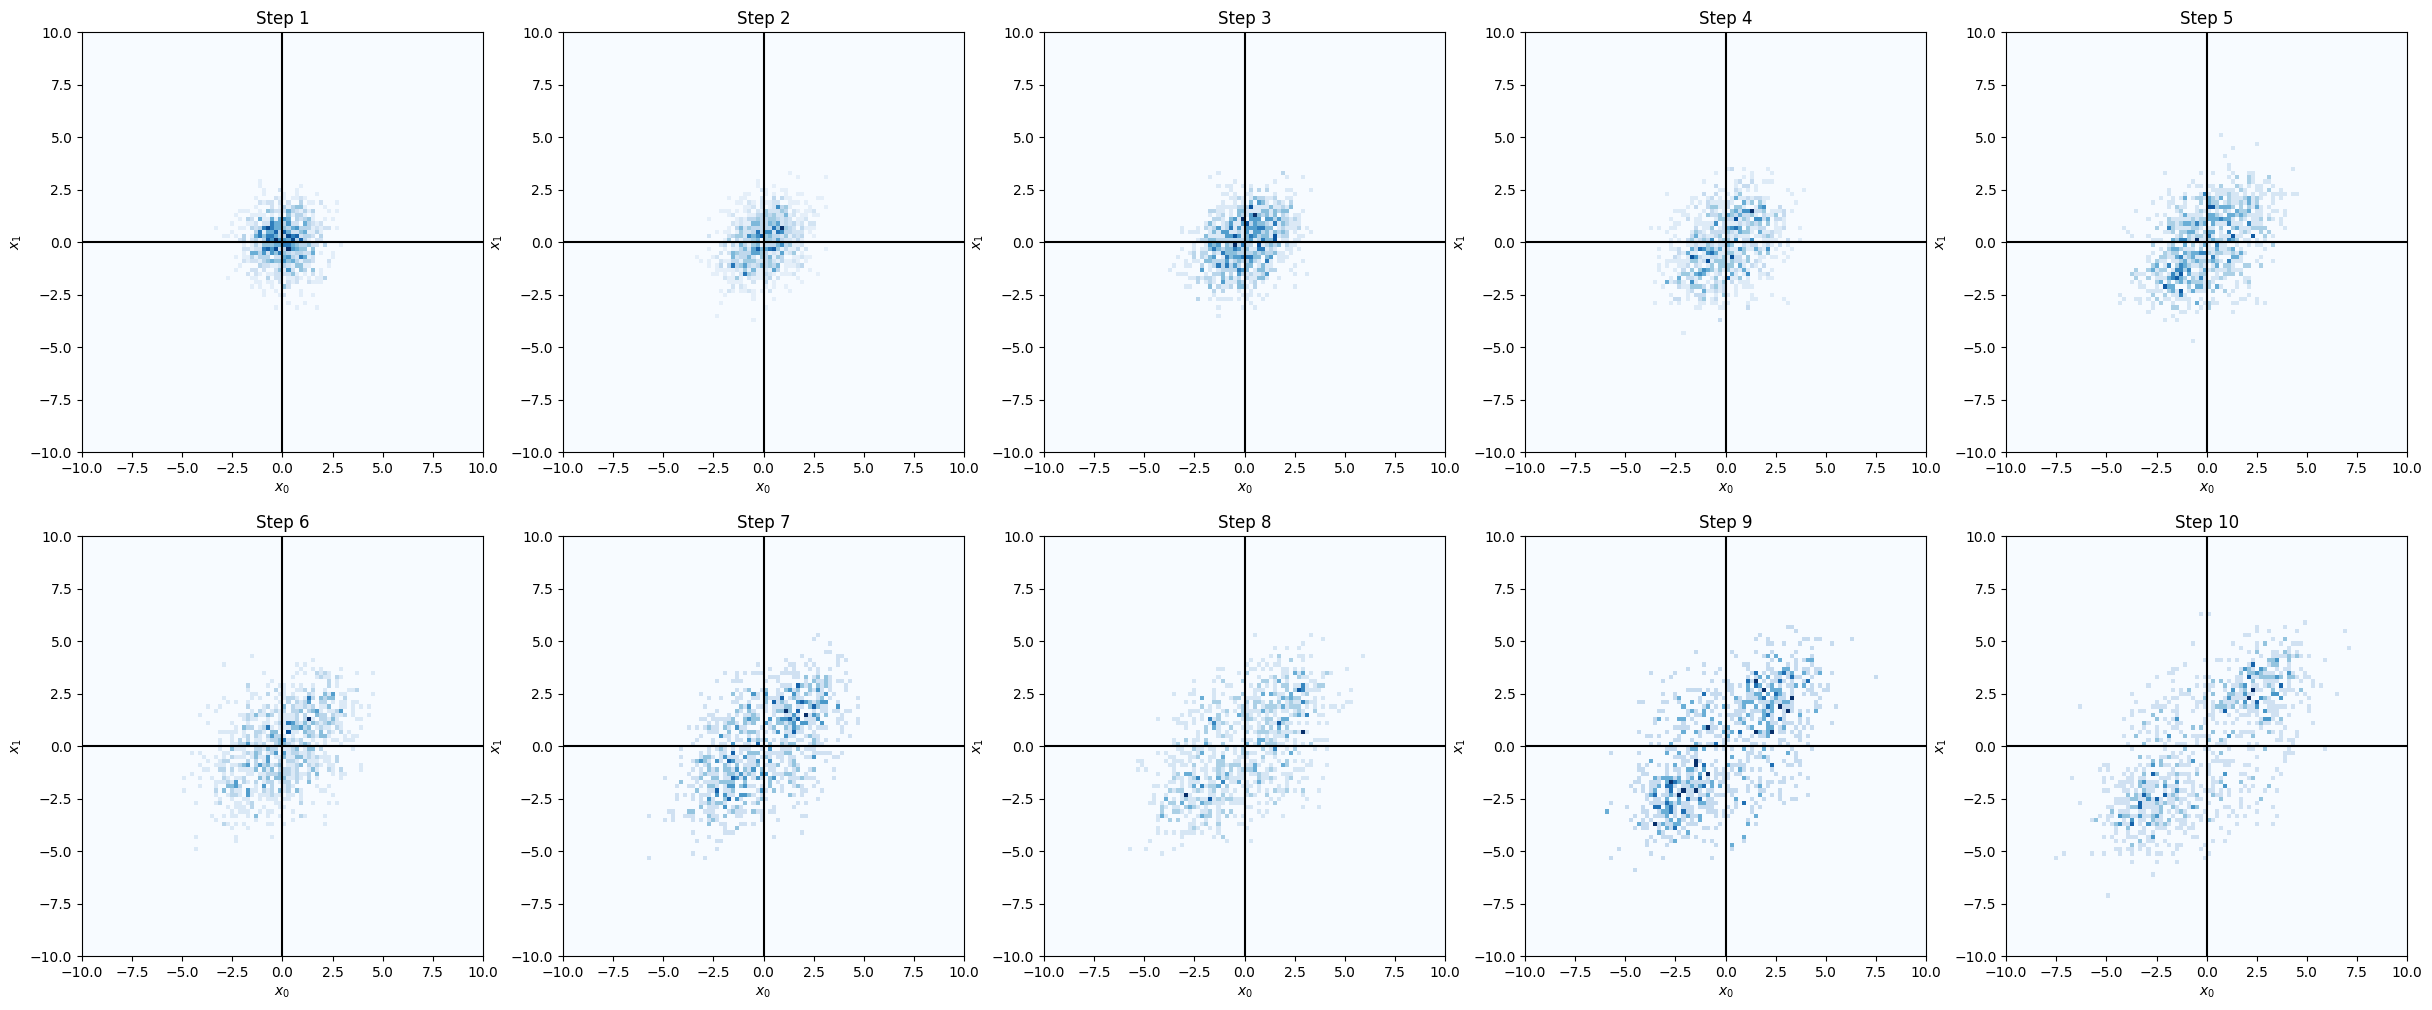

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii+1))
    axes[ii_x,ii_y].hist2d(xx_t[ii*5,:,0], xx_t[ii*5,:,1],bins=100, cmap='Blues',range=np.array([(-10, 10), (-10, 10)]))
    axes[ii_x,ii_y].axhline(0, c="k")
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlabel("$x_{0}$")
    axes[ii_x,ii_y].set_ylabel("$x_{1}$")
plt.show()

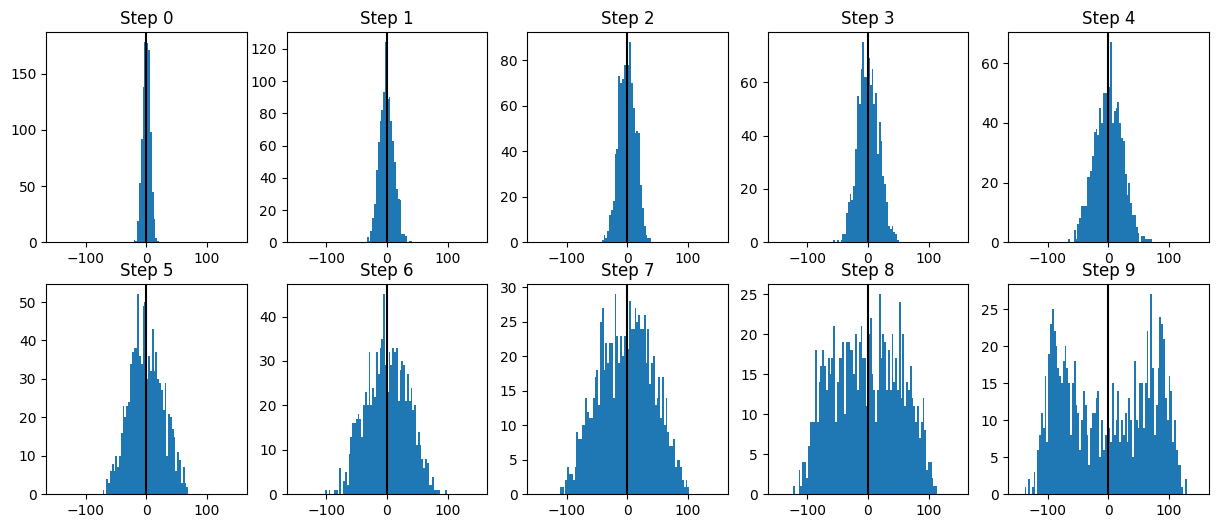

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(xx_t[(ii)*5,:,:].sum(-1),bins=100, range=(-150,150))
    axes[ii_x,ii_y].axvline(0, c="k")
plt.show()

In [ ]:
def fm_loss(model, samples, u_t_label):
    samples.requires_grad_(True)
    u_t_model = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(u_t_label - u_t_model, dim = -1) ** 2 / 2.
    return norm_loss.mean(-1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model_u_t = nn.Sequential(
    nn.Linear(37, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 36)
)

optimizer = optim.Adam(model_u_t.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

l_curve = []
batch_size = 256
samples = np.zeros((batch_size, 37))
print('[Time step, loss value, lr]')
for t in range(20000):
    idx = np.random.choice(NS * NT, batch_size)
    t_idx = idx // NS
    x_idx = idx % NS
    samples[:,0] = t_idx / 10 
    samples[:,1:] = xx_t[t_idx, x_idx, :]
    u_t_label = torch.tensor(u_t_xx[t_idx, x_idx, :]).float()
    loss = fm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    scheduler.step()
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 1000) == 0):
        print([t,loss.item(),scheduler.get_last_lr()])

[Time step, loss value, lr]
[0, 3339550.0, [0.003]]
[1000, 2048643.625, [0.0027]]
[2000, 1758384.0, [0.0024300000000000003]]
[3000, 1929806.375, [0.002187]]
[4000, 1695513.375, [0.0019683]]
[5000, 1716151.75, [0.00177147]]
[6000, 1774280.5, [0.0015943230000000001]]
[7000, 1850370.5, [0.0014348907]]
[8000, 1767070.625, [0.00129140163]]
[9000, 1702445.875, [0.001162261467]]
[10000, 1763267.75, [0.0010460353203000001]]
[11000, 1791267.375, [0.0009414317882700001]]
[12000, 1810621.625, [0.0008472886094430002]]
[13000, 1804188.25, [0.0007625597484987002]]
[14000, 1838576.5, [0.0006863037736488302]]
[15000, 1794693.75, [0.0006176733962839472]]
[16000, 1661607.375, [0.0005559060566555524]]
[17000, 1854034.75, [0.0005003154509899972]]
[18000, 1658527.375, [0.00045028390589099747]]
[19000, 1613891.875, [0.0004052555153018977]]


In [ ]:
print('[Time step, loss value, lr]')
for t in range(20000, 30000):
    idx = np.random.choice(NS * NT, batch_size)
    t_idx = idx // NS
    x_idx = idx % NS
    samples[:,0] = t_idx / 10 
    samples[:,1:] = xx_t[t_idx, x_idx, :]
    u_t_label = torch.tensor(u_t_xx[t_idx, x_idx, :]).float()
    loss = fm_loss(model_u_t, torch.tensor(samples).float(), u_t_label)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    scheduler.step()
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 1000) == 0):
        print([t,loss.item(),scheduler.get_last_lr()])

[Time step, loss value, lr]
[20000, 1708818.5, [0.00036472996377170795]]
[21000, 1633993.25, [0.00032825696739453717]]
[22000, 1684556.625, [0.00029543127065508344]]
[23000, 1630271.625, [0.0002658881435895751]]
[24000, 1527097.25, [0.0002392993292306176]]
[25000, 1745271.375, [0.00021536939630755584]]
[26000, 1794781.0, [0.00019383245667680025]]
[27000, 1631388.0, [0.00017444921100912022]]
[28000, 1701325.75, [0.0001570042899082082]]
[29000, 1713442.125, [0.0001413038609173874]]


In [ ]:
def plot_flow(model):
    sample_size = 10**3
    xx =  torch.normal(0, 1, size=(sample_size ,36))
    xx_t = []
    xx_t.append(xx.detach().numpy())
    plt.figure(figsize=(11,5))
    for ii in range(50):
        tt = ii / 50
        samples = torch.cat((torch.ones(sample_size, 1)*tt, xx), axis = 1)
        u_t = model(samples)
        print("Step = "+str(ii))
        plt.figure(figsize=(11,5))
        plt.subplot(121)
        plt.hist2d(u_t[:,0].detach().numpy(), u_t[:,1].detach().numpy(), bins=100, range=[[u_t_xx[ii].min(),u_t_xx[ii].max()], [u_t_xx[ii].min(), u_t_xx[ii].max()]])
        plt.subplot(122)
        plt.hist2d(u_t_xx[ii][:,0], u_t_xx[ii][:,1], bins=100, range=[[u_t_xx[ii].min(),u_t_xx[ii].max()], [u_t_xx[ii].min(), u_t_xx[ii].max()]])
        plt.show()
        xx = xx + u_t * 1./50
        xx_t.append(xx.detach().numpy())
    xx_t = np.array(xx_t)

    # fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

    # for ii in range(1,11):
    #     ii_y = (ii-1) % 5
    #     ii_x = (ii-1) // 5
    #     axes[ii_x,ii_y].set_title('Step '+str(ii))
    #     axes[ii_x,ii_y].hist2d(xx_t[ii*5,:,0], xx_t[ii*5,:,1],bins=100, cmap='Blues',range=np.array([(-10, 10.0), (-10, 10.0)]))
    #     axes[ii_x,ii_y].set_xlim([-1.5,2])
    #     axes[ii_x,ii_y].set_ylim([-1.5,2])
    
    # plt.show()

# print(u_t_xx.shape)
plot_flow(model_u_t)

# Flow matching with dirichlet path

In [ ]:

def pbc(i,L):
    assert i>=-1 and i<=L
    if i-L == 0:
        return 0
    elif i == -1:
        return L-1
    else:
        return i

def ising_boltzman_prob(logits, J=1):
    assert logits.shape[-1] == 2
    B,H,W,K = logits.shape
    spins = torch.sum(logits*torch.tensor([-1,1], device=logits.device)[None,None,None,:], dim=-1)

    E = torch.zeros(B, device=logits.device)
    for i in range(H):
            E += -(spins[:,i,:]*spins[:,pbc(i-1,L=H),:]*J).sum(dim=-1)
            E += -(spins[:,i,:]*spins[:,pbc(i+1,L=H),:]*J).sum(dim=-1)
    for j in range(W):
            E += -(spins[:,:,j]*spins[:,:,pbc(j-1,L=H)]*J).sum(dim=1)
            E += -(spins[:,:,j]*spins[:,:,pbc(j+1,L=H)]*J).sum(dim=1)

    # for i in range(H):
    #     for j in range(W):
    #         E += -spins[:,i,j]*spins[:,pbc(i-1,L=H),j]*J
    #         E += -spins[:,i,j]*spins[:,pbc(i+1,L=H),j]*J
    #         E += -spins[:,i,j]*spins[:,i,pbc(j-1,L=H)]*J
    #         E += -spins[:,i,j]*spins[:,i,pbc(j+1,L=H)]*J

    E /= 2
    return E

In [ ]:
dataset = np.load("data/ising-latt6x6-T4.0/latt6x6/buffer-S4.00.npy")
dataset[np.where(dataset==-1)]=0
def sample_batch(size):
    # idx = torch.randint(0, len(dataset), (size,))
    # return dataset[idx]
    idx = np.random.choice(np.arange(len(dataset)), size)
    return dataset[idx]

In [ ]:
sigma_0 = 1
mu_0 = 0
sigma_min = 0.0001

#在格点上产生数据
NT = 50
NS = 1000
NS_xxtilde = 1000
xx_t = torch.zeros((NT+1, NS, 36))
# xx_t[0,:,:] = np.random.normal(size=(NS,36))
alphas = torch.ones([NS, 36, 2])
xx_t[0,:,:] = torch.distributions.Dirichlet(alphas).sample()[:,:,0]

p_t_xx_xxtilde = torch.zeros((NT, NS, NS_xxtilde))
p_t_xx = torch.zeros((NT, NS))
u_t_xx_xxtilde = torch.zeros((NT, NS, NS_xxtilde, 36))
u_t_xx = torch.zeros((NT, NS, 36))

for tt in range(NT):
    print('Step: ' + str(tt))
    sigma_tt = (1 - (1-sigma_min) * tt / NT)
    xxtilde = torch.from_numpy(sample_batch(NS_xxtilde)).to(torch.int64)
    e_xxtilde = ising_boltzman_prob(torch.nn.functional.one_hot(xxtilde.reshape(-1), num_classes=2).reshape(NS_xxtilde, 6,6, 2))
    Z = torch.exp(-e_xxtilde*sigma_tt).sum()

    rand_indices = torch.randint(0, 2, (NS, NS, 36))
    rand_onehot = torch.zeros([NS, NS, 36, 2])
    rand_onehot.scatter_(-1, rand_indices.unsqueeze(-1), 1)
    alphas = torch.ones([NS, NS, 36, 2])
    alphas = alphas + sigma_tt*rand_onehot.reshape(NS, NS, 36, 2)
    xx = torch.distributions.Dirichlet(alphas).sample()
    e_xx = ising_boltzman_prob(rand_onehot.reshape(-1,6,6,2)).reshape(NS,NS)
    for ii in range(NS):
        p_xx_xxtilde = torch.exp(-(e_xx[ii,:]-e_xxtilde)*sigma_tt)/Z
        u_t_xx_xxtilde[tt,ii,:,:] = (xxtilde - (1-sigma_min)*xx_t[tt,ii,:].reshape(-1, 36)) / sigma_tt
    p_t_xx[tt, :] = torch.mean(p_t_xx_xxtilde[tt, :, :], axis = 1)
    for ii in range(NS):
        for jj in range(36):
            u_t_xx[tt,ii,jj] = torch.mean(p_t_xx_xxtilde[tt,ii,:] * u_t_xx_xxtilde[tt,ii,:,jj] / p_t_xx[tt,ii])
    xx_t[tt+1,:,:] = xx_t[tt,:,:] + u_t_xx[tt,:,:] * 0.02

In [ ]:
spins = xx_t*(-1.)+(1-xx_t)*1

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(30, 12))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii+1))
    axes[ii_x,ii_y].hist2d(spins[(ii)*5,:,0], spins[ii+1,:,1],bins=100, cmap='Blues',range=np.array([(-3.5, 3.5), (-3.5, 3.5)]))
    axes[ii_x,ii_y].set_xlim([-1.5,2])
    axes[ii_x,ii_y].set_ylim([-1.5,2]) 
    axes[ii_x,ii_y].axhline(0, c="k")
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlabel("$x_{0}$")
    axes[ii_x,ii_y].set_ylabel("$x_{1}$")
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

for ii in range(10):
    ii_y = ii % 5
    ii_x = ii // 5
    axes[ii_x,ii_y].set_title('Step '+str(ii))
    axes[ii_x,ii_y].hist(spins[(ii)*5,:,:].sum(-1),bins=100)
    axes[ii_x,ii_y].axvline(0, c="k")
    axes[ii_x,ii_y].set_xlim((-50,50))
plt.show()

In [ ]:
raise RuntimeError

# Test Harmonic oscillator

In [ ]:
class Harmonic_Oscillator:
    def __init__(self,T):
        self.T = T
        self.kappa = 1.0/T
        self.nvars=[36]

    def energy(self, x):
        return ((x)**2*self.kappa).sum(axis=1)


    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)

    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()

        

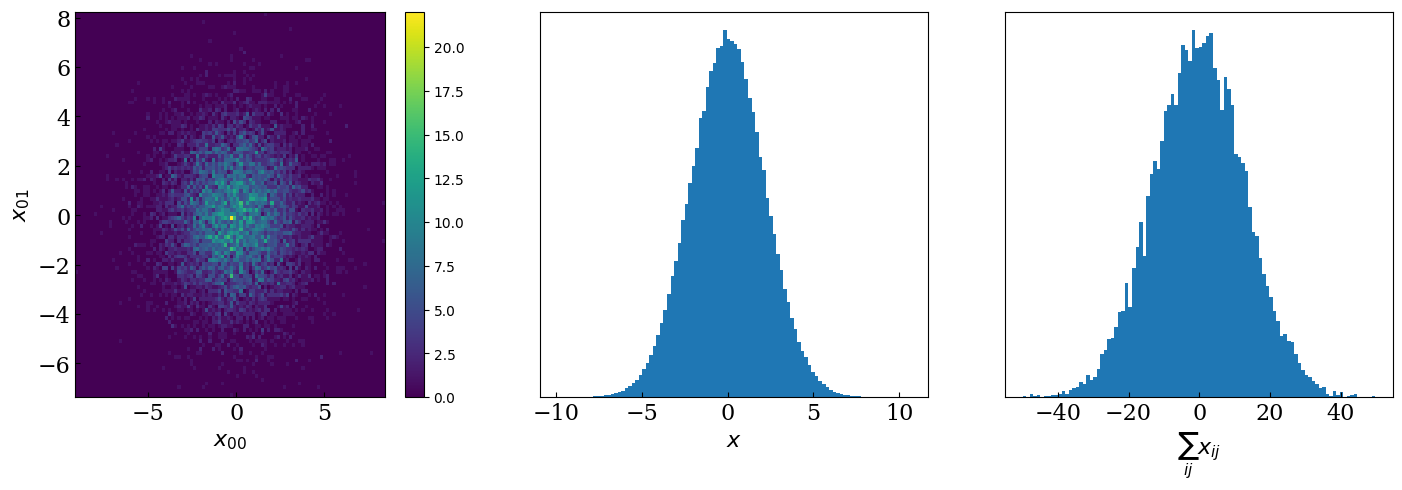

In [ ]:


plt.rcParams['figure.figsize'] = (17, 5)
harmonic_oscillator = Harmonic_Oscillator(10)
xx0 = harmonic_oscillator.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

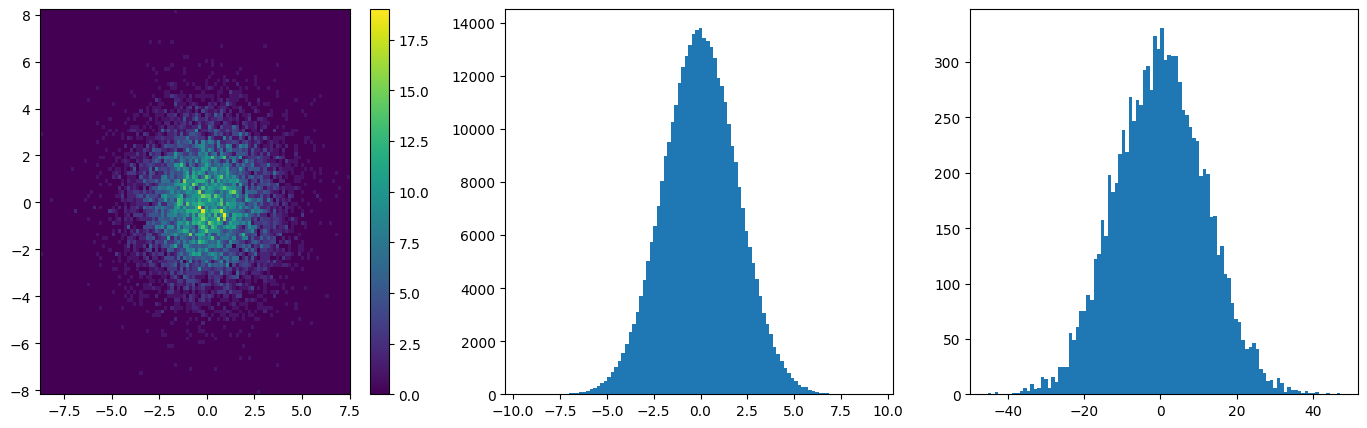

In [ ]:
harmonic_oscillator = Harmonic_Oscillator(5)
xx1 = harmonic_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)

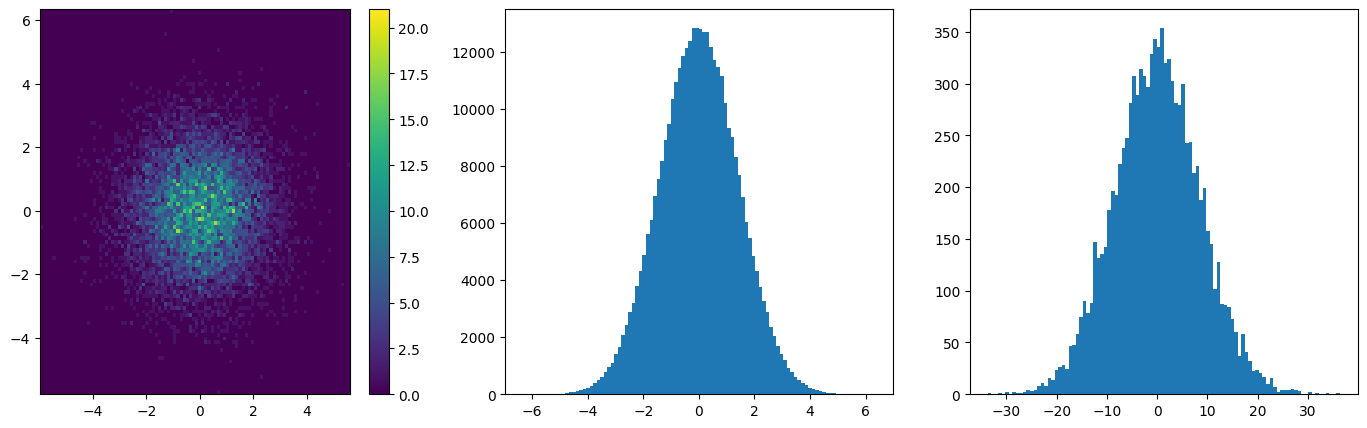

In [ ]:
harmonic_oscillator = Harmonic_Oscillator(4)
xx2 = harmonic_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,36)[:,0], xx2.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,36).sum(-1), bins=100)

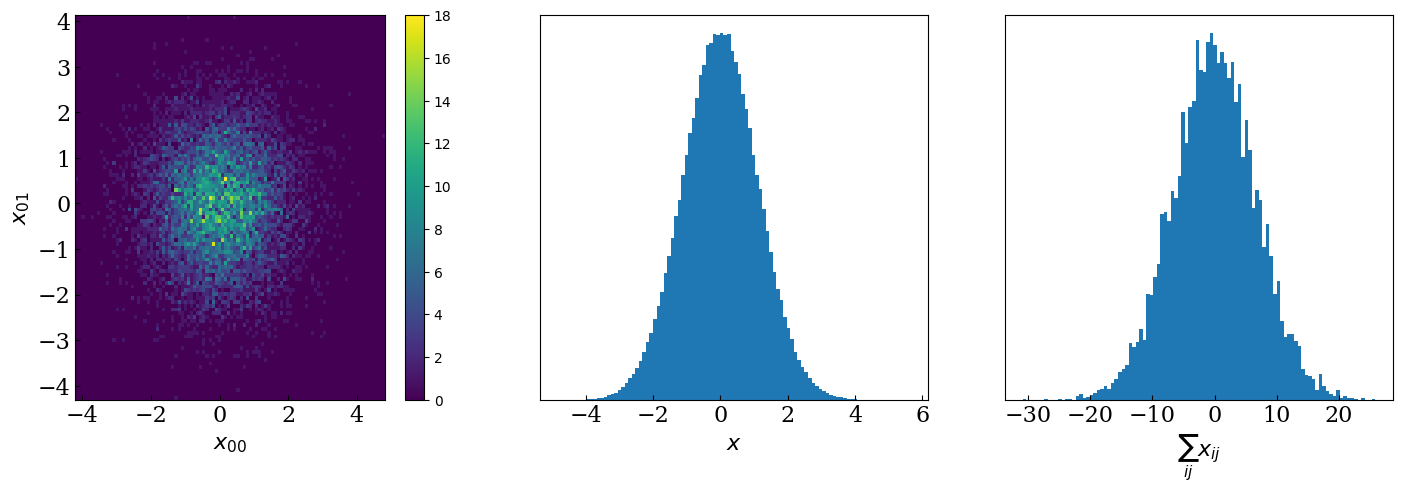

In [ ]:
harmonic_oscillator = Harmonic_Oscillator(2.5)
xx3 = harmonic_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

# Test continous x with nearest neighbor interactions

In [ ]:
class nn_harmonic_oscillator:
    def __init__(self,L,d,beta,name = None):
        if name is None:
            name = "Ising_l"+str(L)+"_d" +str(d)+"_beta"+str(beta)
        self.beta = beta
        self.lattice = Hypercube(L, d, 'periodic')
        K = self.lattice.Adj*beta
        self.K = torch.from_numpy(K).to(torch.float32)
        # w, v = eigh(self.K)    
        # offset = 0.1-w.min()
        # print("offset", offset)
        # self.K += np.eye(w.size)*offset
        # sign, logdet = np.linalg.slogdet(self.K)
        # self.Kinv = torch.from_numpy(inv(self.K)).to(torch.float32)
        self.nvars = [L**d]

    def energy(self,x):
        return -0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.K) * x.reshape(-1, self.nvars[0])).sum(dim=1)

    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)


    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()


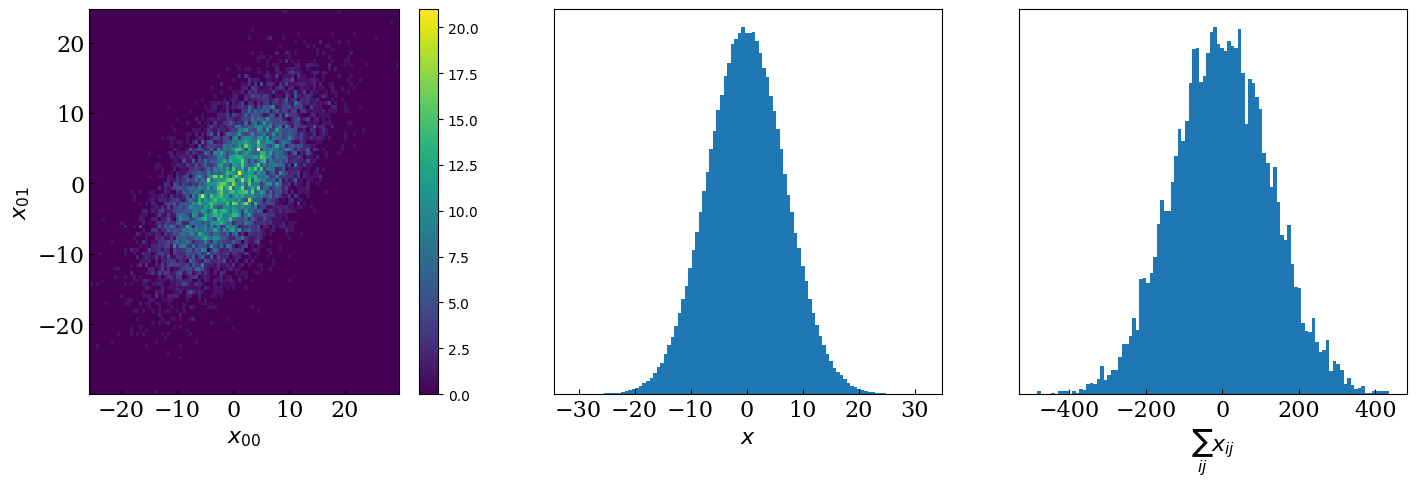

In [ ]:


plt.rcParams['figure.figsize'] = (17, 5)
nn_oscillator = nn_harmonic_oscillator(6,2,0.1)
xx0 = nn_oscillator.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

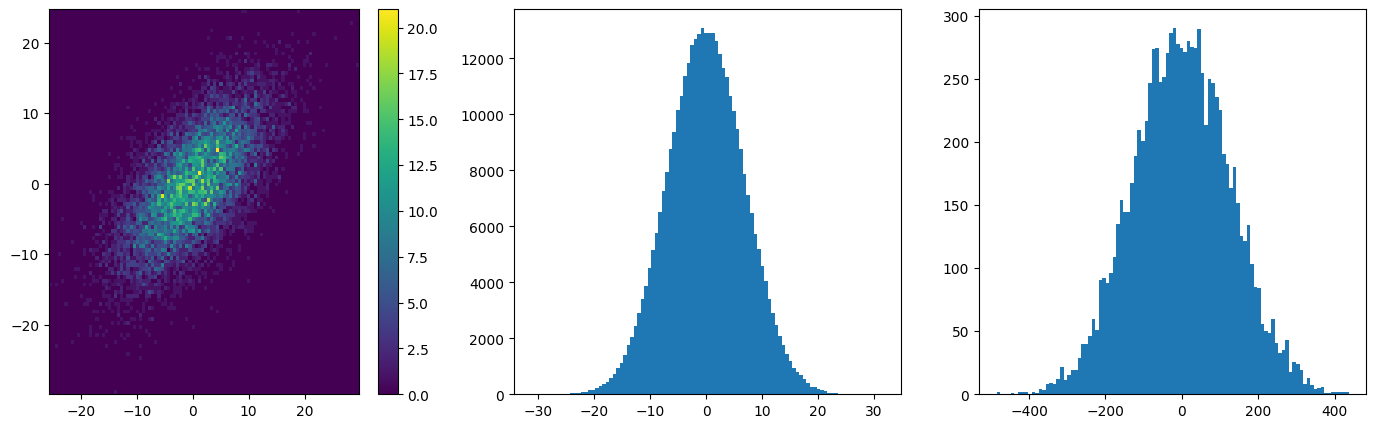

In [ ]:
nn_oscillator = nn_harmonic_oscillator(6,2,0.2)
xx1 = nn_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)

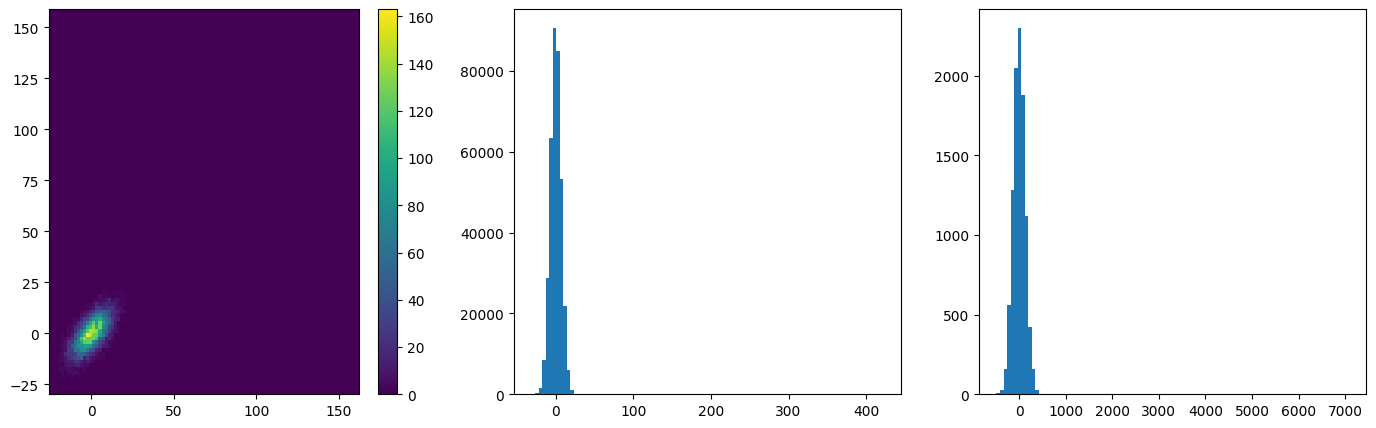

In [ ]:
nn_oscillator = nn_harmonic_oscillator(6,2,0.25)
xx2 = nn_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,36)[:,0], xx2.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,36).sum(-1), bins=100)

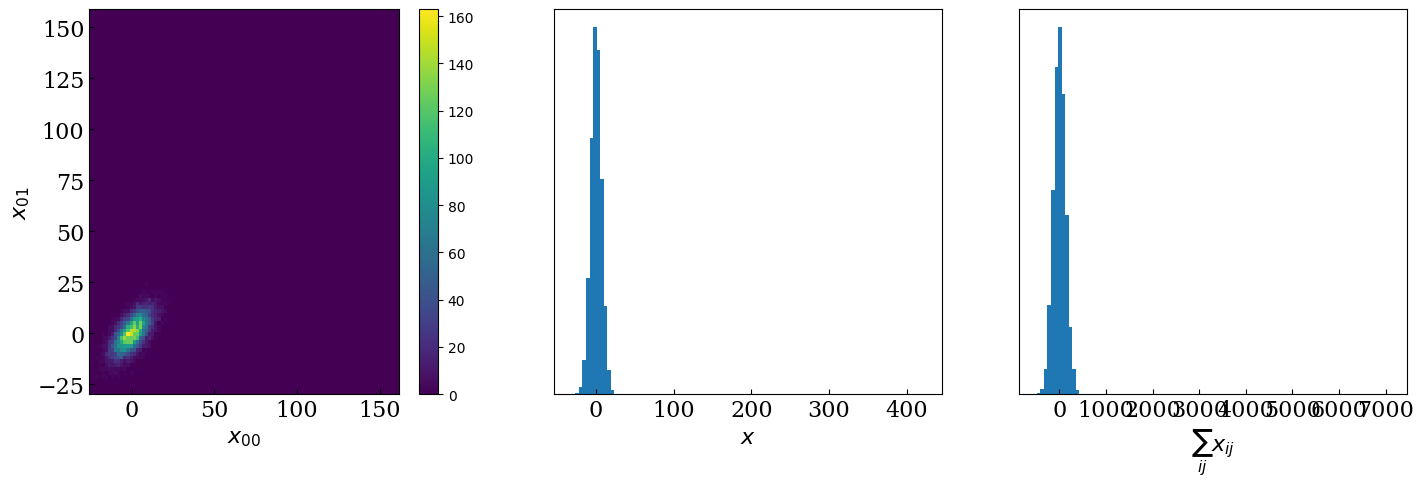

In [ ]:
nn_oscillator = nn_harmonic_oscillator(6,2,0.4)
xx3 = nn_oscillator.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

# Test the gaussian integral continuous Ising model
## Sample by annealing
$k_BT=\infty \rightarrow 10J\rightarrow 5J\rightarrow 4J\rightarrow 2.5J$

### $k_BT=\infty \rightarrow 10J$

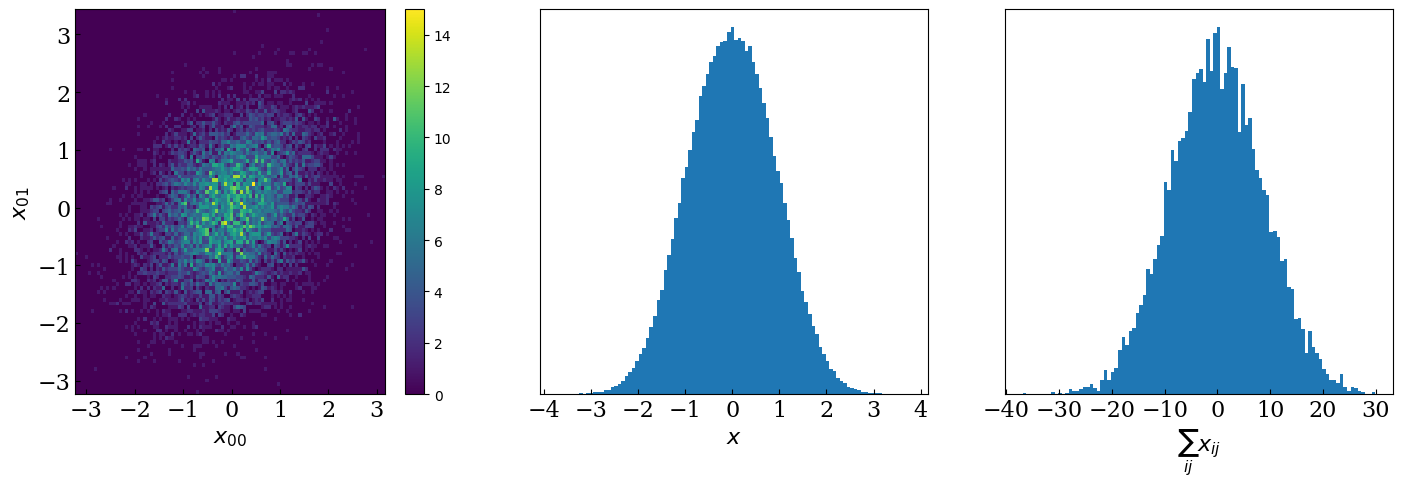

In [9]:
import torch

plt.rcParams['figure.figsize'] = (17, 5)
ising = Ising(6,2,0.1)
xx0 = ising.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

#### MSD

In [ ]:
x_t_list = []
x_t = xx0
ising = Ising(6,2,0.1)
for t in range(1000):
    x_t = ising.sample(1000, thermalSteps = 1, interSteps=10, initial=x_t)
    x_t_list.append(x_t.detach().numpy())
x_t_list = np.array(x_t_list)
MSD_t_list = []
for j in range(1, x_t_list.shape[0]):
    MSD_t_list.append(((x_t_list[j]-x_t_list[0])**2).mean(axis=1))
MSD_t_list = np.array(MSD_t_list)
plt.plot(MSD_t_list[::1,0])

In [ ]:
plt.plot(MSD_t_list[::10,0])

### $k_BT=10J \rightarrow 5J$

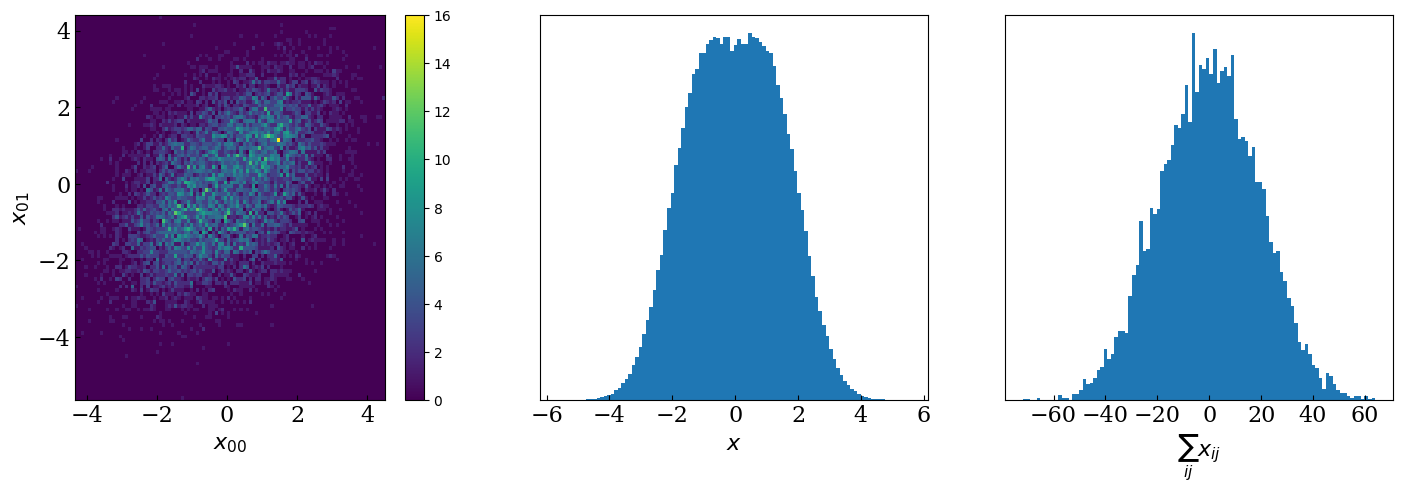

In [10]:
ising = Ising(6,2,0.2)
xx1 = ising.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

### $k_BT=5J \rightarrow 4J$

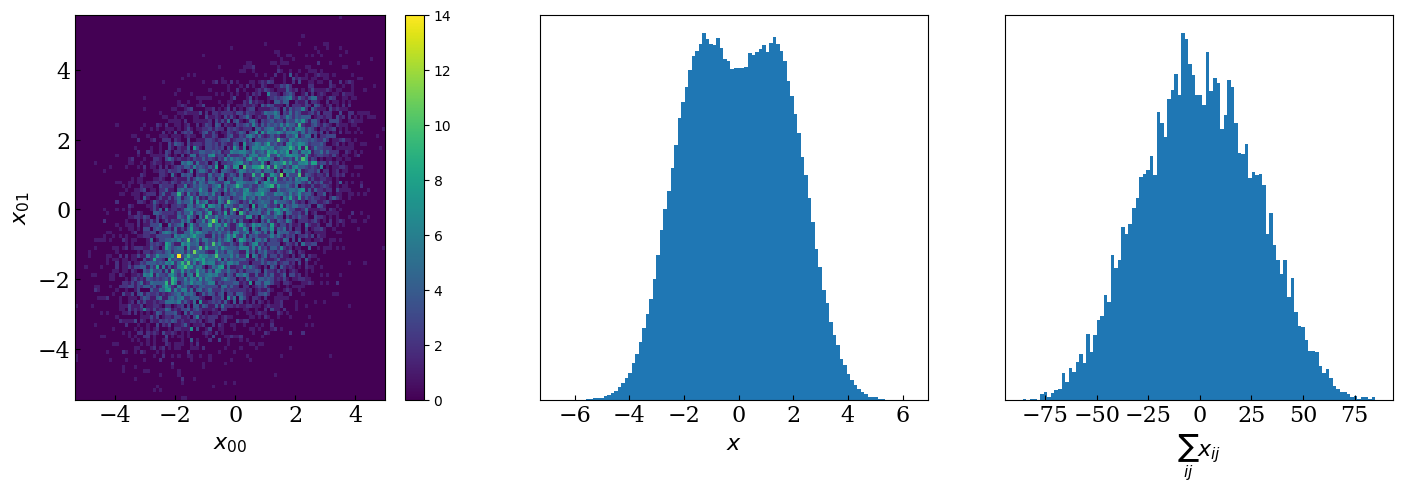

In [11]:
ising = Ising(6,2,0.25)
xx2 = ising.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,36)[:,0], xx2.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

### $k_BT=4J \rightarrow 2.5J$

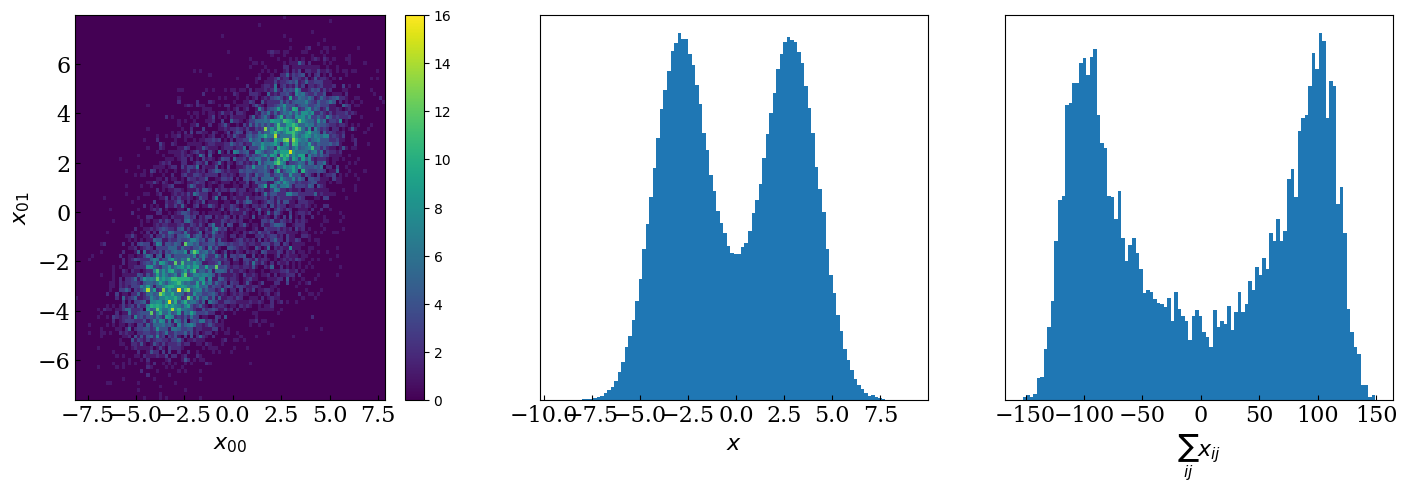

In [12]:
ising = Ising(6,2,0.4)
xx3 = ising.sample(10000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
setfigform_simple("$x_{00}$", "$x_{01}$")
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
setfigform_simple("$x$", "", yticks=[])
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)
setfigform_simple("$\sum_{ij}x_{ij}$", "", yticks=[])

#### MSD

In [ ]:
x_t_list = []
x_t = xx3
ising = Ising(6,2,0.4)
for t in range(20000):
    x_t = ising.sample(1000, thermalSteps = 1, interSteps=1, initial=x_t)
    x_t_list.append(x_t.detach().numpy())
x_t_list = np.array(x_t_list)
MSD_t_list = []
for j in range(1, x_t_list.shape[0]):
    MSD_t_list.append(((x_t_list[j]-x_t_list[0])**2).mean(axis=0))
MSD_t_list = np.array(MSD_t_list)


In [ ]:
print(MSD_t_list.shape)

In [ ]:
from scipy.optimize import curve_fit
def slope(t,s,d0):
    return d0+s*t
popt_list = []
pcov_list = []
for i in range(36):
    trange = np.arange(5001,20000)
    popt, pcov = curve_fit(slope, trange, MSD_t_list[5000:,i])
    popt_list.append(popt)
    pcov_list.append(pcov)
    plt.figure()
    plt.plot(MSD_t_list[:,i])
    plt.plot(trange, slope(trange,*popt))
    plt.title("Site %d"%i)

In [ ]:
popt_list = np.array(popt_list)
D = popt_list.T[0]/0.1/2
print(popt_list.shape)
print(D)

In [ ]:
plt.figure()
plt.subplot(131)
_ = plt.hist2d(x_t_list[100].reshape(-1,36)[:,0], x_t_list[100].reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(x_t_list[100].reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(x_t_list[100].reshape(-1,36).sum(-1), bins=100)

In [ ]:
plt.figure()
plt.subplot(131)
_ = plt.hist2d(x_t_list[-1].reshape(-1,36)[:,0], x_t_list[-1].reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(x_t_list[-1].reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(x_t_list[-1].reshape(-1,36).sum(-1), bins=100)